In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
import warnings
import datetime as dt
from datetime import datetime
warnings.filterwarnings('ignore', '.*do not.*')

# Visualización de Datos

In [21]:
datos= pd.read_csv('servicios.csv', encoding_errors='ignore')
datos= datos.fillna(.001)
datos.rename({'Fecha de cierr': 'Fecha de cierre'})
datos.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
0               53430         31/12/2018          09:35:53     0.001   
1               53431         31/12/2018          09:37:38  00:01:45   
2               53432         31/12/2018          10:04:17  00:26:39   
3               53433         31/12/2018          10:21:16  00:16:59   
4               53434         31/12/2018          10:21:36  00:00:20   

   dif_hr_r_d                  usuarioCaptura  \
0      0.0010     JORGE ARTURO CHAVEZ SAUCEDO   
1      0.0001     JORGE ARTURO CHAVEZ SAUCEDO   
2      0.0008   ZABDI GUADALUPE ALCARAZ CONDE   
3      0.0005  NESTOR ROMAN CASTILLO NUNGARAY   
4      0.0000     JORGE ARTURO CHAVEZ SAUCEDO   

                    TecnicoAsignado   Estatus  \
0                RAUL NAJERA/800146  RESUELTA   
1                RAUL NAJERA/800146  RESUELTA   
2  JOSE DE JESUS GUTIERREZ CASTILLO  RESUELTA   
3            MARTIN MARTINEZ/800192  RESUELTA   
4            JORGE HERNANDEZ/000207  RESUELTA   

                    tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
0                RAUL NAJERA/800146           1  ...          03:37   
1                RAUL NAJERA/800146           1  ...          02:08   
2  JOSE DE JESUS GUTIERREZ CASTILLO           1  ...          05:17   
3            MARTIN MARTINEZ/800192           1  ...          00:23   
4            JORGE HERNANDEZ/000207           1  ...          01:59   

  PorcentajeTR PorcentajeTST                    ProblemaReportado  \
0           90            70       Atoramientos y dobla las hojas   
1           71            63            No funde el tamaño oficio   
2           66            83  cambio de cpu por parte del usuario   
3           10            71                             operador   
4           50            75           mala alimentación de papel   

               FallaReal    Cliente  Referencia  \
0   Guía de cassette1041      0.001       0.001   
1  Se checa sin problema      0.001       0.001   
2  equipo desconfigurado  41017.000       0.001   
3          contaminación      0.001       0.001   
4            atoramiento      0.001       0.001   

                                      Notes  \
0                           8am a 4pm l-v\n   
1                           8am a 4pm l-v\n   
2  LV9-7 FAVOR DE ACUDIR HASTA EL MIÉRCOLES   
3                                HR: 8A1730   
4                     L A V, 8:00 A 10:00\n   

                                  DescripcionReporte    FechaPrimeraVisita  
0  3515942\t1972783\t 31-DEC-2018 08:28:55\tSR MA...  2018-12-31T09:59:00Z  
1  3515943\t1972785\t 31-DEC-2018 08:31:05\tSR MA...  2018-12-31T10:30:00Z  
2                                      CONFIGURACION  2019-01-02T12:03:00Z  
3  3515945\t1972789\t31-DEC-2018 08:36:44\tRUIDOS...  2018-12-31T13:58:00Z  
4  3515940\t1972779\t31-DEC-2018 07:37:19\tSR MAN...  2018-12-31T12:23:00Z  

[5 rows x 40 columns]

## Frecuencia de Estatus

In [22]:
freq=pd.value_counts(datos['Estatus'])
freq

RESUELTA                         137865
PENDIENTE POR PARTES TERCEROS       285
PENDIENTE REFACCION SEITON           77
REFACCIÓN POR INSTALAR IS            54
PENDIENTE POR CLIENTE                27
PENDIENTE POR ASISTENCIA             11
OTROS                                 7
ASIGNADA                              4
PENDIENTE REFACCION PITSS             2
SEGUIMIENTO VISITA CLIENTE            1
Name: Estatus, dtype: int64

In [23]:
frecuencia=pd.DataFrame(freq)
frecuencia.columns = ["Frec_abs"]
frecuencia["Frec_rel_%"] = 100*frecuencia["Frec_abs"]/len(datos)
frecuencia

Frec_abs  Frec_rel_%
RESUELTA                         137865   99.661686
PENDIENTE POR PARTES TERCEROS       285    0.206025
PENDIENTE REFACCION SEITON           77    0.055663
REFACCIÓN POR INSTALAR IS            54    0.039036
PENDIENTE POR CLIENTE                27    0.019518
PENDIENTE POR ASISTENCIA             11    0.007952
OTROS                                 7    0.005060
ASIGNADA                              4    0.002892
PENDIENTE REFACCION PITSS             2    0.001446
SEGUIMIENTO VISITA CLIENTE            1    0.000723

- El 99.7% de nuestros datos representan procesos resueltos por exelpits, por lo tanto en < del 1% se distribuyen los diversos Estatus en los que se al día de hoy se encuetra el proceso con de la empresa con el cliente

## Tabla de Procesos Resueltos

In [24]:
Procesos_resueltos=datos[datos['Estatus']=='RESUELTA']
Procesos_resueltos.head(5)

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
0               53430         31/12/2018          09:35:53     0.001   
1               53431         31/12/2018          09:37:38  00:01:45   
2               53432         31/12/2018          10:04:17  00:26:39   
3               53433         31/12/2018          10:21:16  00:16:59   
4               53434         31/12/2018          10:21:36  00:00:20   

   dif_hr_r_d                  usuarioCaptura  \
0      0.0010     JORGE ARTURO CHAVEZ SAUCEDO   
1      0.0001     JORGE ARTURO CHAVEZ SAUCEDO   
2      0.0008   ZABDI GUADALUPE ALCARAZ CONDE   
3      0.0005  NESTOR ROMAN CASTILLO NUNGARAY   
4      0.0000     JORGE ARTURO CHAVEZ SAUCEDO   

                    TecnicoAsignado   Estatus  \
0                RAUL NAJERA/800146  RESUELTA   
1                RAUL NAJERA/800146  RESUELTA   
2  JOSE DE JESUS GUTIERREZ CASTILLO  RESUELTA   
3            MARTIN MARTINEZ/800192  RESUELTA   
4            JORGE HERNANDEZ/000207  RESUELTA   

                    tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
0                RAUL NAJERA/800146           1  ...          03:37   
1                RAUL NAJERA/800146           1  ...          02:08   
2  JOSE DE JESUS GUTIERREZ CASTILLO           1  ...          05:17   
3            MARTIN MARTINEZ/800192           1  ...          00:23   
4            JORGE HERNANDEZ/000207           1  ...          01:59   

  PorcentajeTR PorcentajeTST                    ProblemaReportado  \
0           90            70       Atoramientos y dobla las hojas   
1           71            63            No funde el tamaño oficio   
2           66            83  cambio de cpu por parte del usuario   
3           10            71                             operador   
4           50            75           mala alimentación de papel   

               FallaReal    Cliente  Referencia  \
0   Guía de cassette1041      0.001       0.001   
1  Se checa sin problema      0.001       0.001   
2  equipo desconfigurado  41017.000       0.001   
3          contaminación      0.001       0.001   
4            atoramiento      0.001       0.001   

                                      Notes  \
0                           8am a 4pm l-v\n   
1                           8am a 4pm l-v\n   
2  LV9-7 FAVOR DE ACUDIR HASTA EL MIÉRCOLES   
3                                HR: 8A1730   
4                     L A V, 8:00 A 10:00\n   

                                  DescripcionReporte    FechaPrimeraVisita  
0  3515942\t1972783\t 31-DEC-2018 08:28:55\tSR MA...  2018-12-31T09:59:00Z  
1  3515943\t1972785\t 31-DEC-2018 08:31:05\tSR MA...  2018-12-31T10:30:00Z  
2                                      CONFIGURACION  2019-01-02T12:03:00Z  
3  3515945\t1972789\t31-DEC-2018 08:36:44\tRUIDOS...  2018-12-31T13:58:00Z  
4  3515940\t1972779\t31-DEC-2018 07:37:19\tSR MAN...  2018-12-31T12:23:00Z  

[5 rows x 40 columns]

## Frecuencia relativa de Días trascurridos para que el proceso sea Resuelto

In [25]:
freq2= pd.value_counts(Procesos_resueltos['dia_trans'])
frecuencia2=pd.DataFrame(freq2)
frecuencia2.columns = ["Frec_abs"]
frecuencia2["Frec_rel_%"] = 100*frecuencia2["Frec_abs"]/len(Procesos_resueltos)
frecuencia2.index.name="Días"
frecuencia2.head(10)

Frec_abs  Frec_rel_%
Días                      
1        87442   63.425815
3         7330    5.316795
2         6972    5.057121
4         4770    3.459906
5         4030    2.923149
6         3791    2.749791
7         3404    2.469082
8         2170    1.574004
9         1398    1.014035
11        1107    0.802959

In [26]:
print(f'El porcentaje de datos distribuidos en los primeros 22 días es del',np.round((sum(frecuencia2['Frec_rel_%'][:22])),2),'%')

El porcentaje de datos distribuidos en los primeros 22 días es del 95.14 %


- Observado lo anterior, podemos descartar a partir del día 23 porque el nivel de significancia dentro de nuestros datos no es relevante

## Tabla de Procesos Resueltos dentro de los primeros 22 días.

In [27]:
Procesos_resueltos_22=datos[(datos['Estatus']=='RESUELTA') & (datos['dia_trans'] <= 22)]
Procesos_resueltos_22.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
0               53430         31/12/2018          09:35:53     0.001   
1               53431         31/12/2018          09:37:38  00:01:45   
2               53432         31/12/2018          10:04:17  00:26:39   
3               53433         31/12/2018          10:21:16  00:16:59   
4               53434         31/12/2018          10:21:36  00:00:20   

   dif_hr_r_d                  usuarioCaptura  \
0      0.0010     JORGE ARTURO CHAVEZ SAUCEDO   
1      0.0001     JORGE ARTURO CHAVEZ SAUCEDO   
2      0.0008   ZABDI GUADALUPE ALCARAZ CONDE   
3      0.0005  NESTOR ROMAN CASTILLO NUNGARAY   
4      0.0000     JORGE ARTURO CHAVEZ SAUCEDO   

                    TecnicoAsignado   Estatus  \
0                RAUL NAJERA/800146  RESUELTA   
1                RAUL NAJERA/800146  RESUELTA   
2  JOSE DE JESUS GUTIERREZ CASTILLO  RESUELTA   
3            MARTIN MARTINEZ/800192  RESUELTA   
4            JORGE HERNANDEZ/000207  RESUELTA   

                    tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
0                RAUL NAJERA/800146           1  ...          03:37   
1                RAUL NAJERA/800146           1  ...          02:08   
2  JOSE DE JESUS GUTIERREZ CASTILLO           1  ...          05:17   
3            MARTIN MARTINEZ/800192           1  ...          00:23   
4            JORGE HERNANDEZ/000207           1  ...          01:59   

  PorcentajeTR PorcentajeTST                    ProblemaReportado  \
0           90            70       Atoramientos y dobla las hojas   
1           71            63            No funde el tamaño oficio   
2           66            83  cambio de cpu por parte del usuario   
3           10            71                             operador   
4           50            75           mala alimentación de papel   

               FallaReal    Cliente  Referencia  \
0   Guía de cassette1041      0.001       0.001   
1  Se checa sin problema      0.001       0.001   
2  equipo desconfigurado  41017.000       0.001   
3          contaminación      0.001       0.001   
4            atoramiento      0.001       0.001   

                                      Notes  \
0                           8am a 4pm l-v\n   
1                           8am a 4pm l-v\n   
2  LV9-7 FAVOR DE ACUDIR HASTA EL MIÉRCOLES   
3                                HR: 8A1730   
4                     L A V, 8:00 A 10:00\n   

                                  DescripcionReporte    FechaPrimeraVisita  
0  3515942\t1972783\t 31-DEC-2018 08:28:55\tSR MA...  2018-12-31T09:59:00Z  
1  3515943\t1972785\t 31-DEC-2018 08:31:05\tSR MA...  2018-12-31T10:30:00Z  
2                                      CONFIGURACION  2019-01-02T12:03:00Z  
3  3515945\t1972789\t31-DEC-2018 08:36:44\tRUIDOS...  2018-12-31T13:58:00Z  
4  3515940\t1972779\t31-DEC-2018 07:37:19\tSR MAN...  2018-12-31T12:23:00Z  

[5 rows x 40 columns]

In [28]:
freq3= pd.value_counts(Procesos_resueltos_22['ServiceRouteName'])
frecuencia3=pd.DataFrame(freq3)
frecuencia3.columns = ["Frec_abs"]
frecuencia3["Frec_rel_%"] = 100*frecuencia3["Frec_abs"]/len(Procesos_resueltos_22)
frecuencia3.index.name='Estado'
display(frecuencia3.head(10)) ,display(frecuencia3.tail(10))

Frec_abs  Frec_rel_%
Estado                                
JALISCO              59812   45.600579
ESTADO DE MEXICO     13164   10.036214
CHIHUAHUA             9936    7.575192
NUEVO LEON            9777    7.453970
CIUDAD DE MEXICO      6928    5.281897
COAHUILA              5100    3.888232
GUANAJUATO            4374    3.334731
QUERETARO             3407    2.597492
TAMAULIPAS            3387    2.582244
MICHOACAN             2435    1.856440

Frec_abs  Frec_rel_%
Estado                               
OAXACA                201    0.153242
GENERAL               200    0.152480
BAJA CALIFORNIA       176    0.134182
NAYARIT               175    0.133420
MORELOS               175    0.133420
QUINTANA ROO          156    0.118934
GUERRERO              112    0.085389
TLAXCALA               70    0.053368
CAMPECHE               40    0.030496
0.001                   4    0.003050

(None, None)

## Segmentación de regiones:
- Procederemos a realizar una regionalización del pais respecto a la Ruta de servicio y observar de manera porcionada el cambio que se obtiene al analizar el tiempo de recepción, tiempo de y tiempo de respuesta para evaluar el comportamiento del modelo en cuestión.
- Crearemos Nuestras regiones con base en las regiones economicas del país.

<img src=https://geografiaeconomicaunivia.files.wordpress.com/2014/09/regiones.png>

# Procesos Resueltos En Menos de 22 Días por Regiones

### Region Norte

In [29]:
Procesos_resueltos_22_CH=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'CHIHUAHUA')]
Procesos_resueltos_22_COA=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'COAHUILA')]
Procesos_resueltos_22_ZAC=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'ZACATECAS')]
Procesos_resueltos_22_DUR=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'DURANGO')]
Procesos_resueltos_22_SLP=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'SAN LUIS POTOSI')]
Procesos_resueltos_22_N=pd.concat([Procesos_resueltos_22_CH,
                                  Procesos_resueltos_22_COA,
                                 Procesos_resueltos_22_ZAC,
                                 Procesos_resueltos_22_DUR,
                                 Procesos_resueltos_22_SLP])
Procesos_resueltos_22_N.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
15               53446         01/01/2019          21:32:59  00:53:19   
16               53447         01/01/2019          22:24:09  00:51:10   
52               53485         02/01/2019          10:38:48  00:03:57   
72               53506         02/01/2019          11:42:01  00:00:52   
80               53514         02/01/2019          11:51:20  00:03:35   

    dif_hr_r_d               usuarioCaptura            TecnicoAsignado  \
15      0.0015     LUIS EDUARDO MUÑOZ REYES  LUIS EDUARDO MUÑOZ/500159   
16      0.0015          RAMIRO IBARRA RAMOS       RAMIRO IBARRA/800071   
52      0.0001  JORGE ARTURO CHAVEZ SAUCEDO  LUIS EDUARDO MUÑOZ/500159   
72      0.0000  JORGE ARTURO CHAVEZ SAUCEDO        RAFAEL CASAS/500027   
80      0.0001  JORGE ARTURO CHAVEZ SAUCEDO   MIGUEL ANGEL COTA/500156   

     Estatus            tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
15  RESUELTA  LUIS EDUARDO MUÑOZ/500159           1  ...          04:00   
16  RESUELTA       RAMIRO IBARRA/800071           1  ...          04:00   
52  RESUELTA  LUIS EDUARDO MUÑOZ/500159           2  ...          02:59   
72  RESUELTA        RAFAEL CASAS/500027           2  ...          -0:44   
80  RESUELTA   MIGUEL ANGEL COTA/500156           2  ...          04:00   

   PorcentajeTR PorcentajeTST            ProblemaReportado  \
15           75            92                         MTTO   
16           75            92                     rodillos   
52           75            81                 atoramientos   
72          -18            34  sensores de registro dañado   
80           75            70                 atoramientos   

                              FallaReal  Cliente  Referencia  \
15                                 MTTO    0.001       0.001   
16                                atora    0.001       0.001   
52                         atoramientos    0.001       0.001   
72                        sensor dañado    0.001       0.001   
80  ensamble de registro y Fusor dañado    0.001       0.001   

                               Notes  \
15                             0.001   
16                             0.001   
52  Cristobal.Torres@Honeywell.com\n   
72              L a V de 8 a 15:30\n   
80               HORARIO DE 9 A 19\n   

                                   DescripcionReporte    FechaPrimeraVisita  
15                                               MTTO  2019-01-02T08:24:00Z  
16                                              atora  2019-01-02T08:00:00Z  
52  3516116\t1973489\t 02-JAN-2019 10:17:41\tSR MA...  2019-01-02T11:40:00Z  
72  3516182\t1973605\t 02-JAN-2019 11:32:17\tSR MA...  2019-01-02T16:50:00Z  
80  3516193\t1973623\t 02-JAN-2019 11:45:50\tSR MA...  2019-01-02T11:30:00Z  

[5 rows x 40 columns]

### Region Noroeste

In [30]:
Procesos_resueltos_22_BJ=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'BAJA CALIFORNIA')]
Procesos_resueltos_22_BJS=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'BAJA CALIFORNIA SUR')]
Procesos_resueltos_22_SON=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'SONORA')]
Procesos_resueltos_22_SIN=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'SINALOA')]
Procesos_resueltos_22_NAY=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'NAYARIT')]
Procesos_resueltos_22_NO=pd.concat([Procesos_resueltos_22_BJ,
                                  Procesos_resueltos_22_BJS,
                                 Procesos_resueltos_22_SON,
                                 Procesos_resueltos_22_SIN,
                                 Procesos_resueltos_22_NAY])
Procesos_resueltos_22_NO.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
2799               56350         18/01/2019          10:31:09  00:04:01   
2818               56369         18/01/2019          11:02:50  00:02:21   
2893               56446         18/01/2019          15:05:57  00:00:24   
2977               56531         21/01/2019          09:34:56  00:06:20   
3554               57127         23/01/2019          12:16:09  00:01:21   

      dif_hr_r_d                  usuarioCaptura              TecnicoAsignado  \
2799      0.0001     JESUS ALFREDO SAUCEDO DURAN  JESUS ALFREDO SAUCEDO DURAN   
2818      0.0001     JESUS ALFREDO SAUCEDO DURAN  JESUS ALFREDO SAUCEDO DURAN   
2893      0.0000            VALERIA TORRES GÓMEZ   MARTHA LILIANA DIAZ/500165   
2977      0.0002           PAUL GONZALEZ RAMIREZ   SERVICIO RED EXTERNA PITSS   
3554      0.0000  NESTOR ROMAN CASTILLO NUNGARAY   SERVICIO RED EXTERNA XEROX   

       Estatus              tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
2799  RESUELTA  JESUS ALFREDO SAUCEDO DURAN           1  ...          02:00   
2818  RESUELTA  JESUS ALFREDO SAUCEDO DURAN           1  ...          02:00   
2893  RESUELTA   MARTHA LILIANA DIAZ/500165           1  ...        #VALOR!   
2977  RESUELTA   SERVICIO RED EXTERNA PITSS           1  ...       70:12:00   
3554  RESUELTA   SERVICIO RED EXTERNA XEROX           1  ...          05:00   

     PorcentajeTR PorcentajeTST         ProblemaReportado  \
2799           50            50           INSTALACION SPS   
2818           50            50           INSTALACION SPS   
2893          -41            97          SURTIDO DE TONER   
2977           98            98                         0   
3554           80            98  Mantenimiento Preventivo   

                     FallaReal  Cliente  Referencia  \
2799           INSTALACION SPS     91.0       0.001   
2818           INSTALACION SPS     91.0       0.001   
2893            FALTA DE TONER   8741.0       0.001   
2977                         0     91.0       0.001   
3554  Mantenimiento Preventivo  41888.0       0.001   

                                                  Notes  \
2799                                              0.001   
2818                                              0.001   
2893                                             9AM4PM   
2977  HORARIO:9:00AM A 5:00PM  55229900 EXT 110 PERS...   
3554                                              0.001   

                    DescripcionReporte    FechaPrimeraVisita  
2799                                 1  2019-01-18T10:31:00Z  
2818                                 1  2019-01-18T11:04:00Z  
2893                            TONER   2019-01-24T13:00:00Z  
2977  MACHAS  HORARIO:9:00AM A 5:00PM   2019-01-23T00:02:00Z  
3554                     MANTENIMIENTO  2019-02-12T12:00:00Z  

[5 rows x 40 columns]

### Region Noreste

In [31]:
Procesos_resueltos_22_NL=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'NUEVO LEON')]
Procesos_resueltos_22_TMPS=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'TAMAULIPAS')]
Procesos_resueltos_22_NE=pd.concat([Procesos_resueltos_22_NL,
                                  Procesos_resueltos_22_TMPS])
Procesos_resueltos_22_NE.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
7                53437         31/12/2018          10:23:41  00:01:04   
10               53440         31/12/2018          10:45:19  00:02:45   
14               53445         01/01/2019          20:39:40  00:58:28   
18               53449         02/01/2019          07:07:16  16:40:28   
21               53452         02/01/2019          08:08:38  00:04:16   

    dif_hr_r_d                  usuarioCaptura  \
7       0.0000  NESTOR ROMAN CASTILLO NUNGARAY   
10      0.0001  NESTOR ROMAN CASTILLO NUNGARAY   
14      0.0017       SALVADOR CHAVEZ DOMINGUEZ   
18      0.0289          TOMAS MARTINEZ MORALES   
21      0.0001  NESTOR ROMAN CASTILLO NUNGARAY   

                   TecnicoAsignado   Estatus                 tecnicoEjecutor  \
7        CESAR PEREZ BALBOA/500028  RESUELTA       CESAR PEREZ BALBOA/500028   
10       CESAR PEREZ BALBOA/500028  RESUELTA       CESAR PEREZ BALBOA/500028   
14          SALVADOR CHAVEZ/500060  RESUELTA          SALVADOR CHAVEZ/500060   
18           TOMAS MARTINEZ/500036  RESUELTA           TOMAS MARTINEZ/500036   
21  JUAN GUADALUPE ESCOBEDO/500083  RESUELTA  JUAN GUADALUPE ESCOBEDO/500083   

    NumVisitas  ... TiempoRestante PorcentajeTR PorcentajeTST  \
7            1  ...          02:54           73            74   
10           1  ...              0          -56            48   
14           1  ...       36:00:00           97            98   
18           1  ...       36:00:00           97            98   
21           1  ...              0          -39            32   

    ProblemaReportado              FallaReal    Cliente  Referencia  \
7             042-326                042-326      0.001       0.001   
10     falla escáner          falla escáner       0.001       0.001   
14               mtto                   mtto  32597.000       0.001   
18             rev eq                 rev eq  41486.000       0.001   
21     piezas sueltas  no funciona charola 5      0.001       0.001   

                    Notes                                 DescripcionReporte  \
7           9AM A 9PM L-V  3515941\t1972781\t31-DEC-2018 08:06:56\tcode d...   
10  L a V de 7 a 18 hrs\n  3515949\t1972797\t31-DEC-2018 10:23:07\tSR MAN...   
14                  0.001                                    mtto preventivo   
18                  0.001                                      rev eq inicio   
21  L A V, 9:00 A 21:00\n  3515974\t1972189\t01-JAN-2019 23:12:42\tSR MAN...   

      FechaPrimeraVisita  
7   2018-12-31T11:30:00Z  
10  2019-01-02T08:00:00Z  
14  2019-01-02T08:00:00Z  
18  2019-01-02T08:04:00Z  
21  2019-01-02T14:03:00Z  

[5 rows x 40 columns]

### Region Centro Occidente

In [32]:
Procesos_resueltos_22_JAL=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'JALISCO')]
Procesos_resueltos_22_AGS=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'AGUASCALIENTES')]
Procesos_resueltos_22_COL=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'COLIMA')]
Procesos_resueltos_22_MICH=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'MICHOACAN')]
Procesos_resueltos_22_GTO=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'GUANAJUATO')]
Procesos_resueltos_22_CO=pd.concat([Procesos_resueltos_22_JAL,
                                  Procesos_resueltos_22_AGS,
                                 Procesos_resueltos_22_COL,
                                 Procesos_resueltos_22_MICH,
                                 Procesos_resueltos_22_GTO])
Procesos_resueltos_22_CO.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
2                53432         31/12/2018          10:04:17  00:26:39   
3                53433         31/12/2018          10:21:16  00:16:59   
5                53435         31/12/2018          10:22:21  00:00:45   
11               53441         31/12/2018          12:17:57  01:32:38   
12               53442         01/01/2019          19:28:05  07:10:08   

    dif_hr_r_d                  usuarioCaptura  \
2       0.0008   ZABDI GUADALUPE ALCARAZ CONDE   
3       0.0005  NESTOR ROMAN CASTILLO NUNGARAY   
5       0.0000  NESTOR ROMAN CASTILLO NUNGARAY   
11      0.0027        CARLOS GUITIERREZ/800196   
12      0.0124  NESTOR ROMAN CASTILLO NUNGARAY   

                     TecnicoAsignado   Estatus  \
2   JOSE DE JESUS GUTIERREZ CASTILLO  RESUELTA   
3             MARTIN MARTINEZ/800192  RESUELTA   
5             MARTIN MARTINEZ/800192  RESUELTA   
11           CARLOS GUTIERREZ/800196  RESUELTA   
12           CARLOS GUTIERREZ/800196  RESUELTA   

                     tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
2   JOSE DE JESUS GUTIERREZ CASTILLO           1  ...          05:17   
3             MARTIN MARTINEZ/800192           1  ...          00:23   
5             MARTIN MARTINEZ/800192           1  ...          00:00   
11           CARLOS GUTIERREZ/800196           1  ...          05:00   
12           CARLOS GUTIERREZ/800196           1  ...          04:53   

   PorcentajeTR PorcentajeTST                        ProblemaReportado  \
2            66            83      cambio de cpu por parte del usuario   
3            10            71                                 operador   
5             0            65                                   papel    
11           80            98  Guía Caída del ADF, no actuaba sensores   
12           98            98            guías desajustadas del bypass   

                            FallaReal    Cliente  Referencia  \
2               equipo desconfigurado  41017.000       0.001   
3                       contaminación      0.001       0.001   
5               engranaje contaminado      0.001       0.001   
11  Equipo bloqueado por causa de ADF  41888.000       0.001   
12         atorantamentos por by pass  41888.000       0.001   

                                       Notes  \
2   LV9-7 FAVOR DE ACUDIR HASTA EL MIÉRCOLES   
3                                 HR: 8A1730   
5                                 HR: 8A1730   
11                                     0.001   
12                                  8 A 18PM   

                                   DescripcionReporte    FechaPrimeraVisita  
2                                       CONFIGURACION  2019-01-02T12:03:00Z  
3   3515945\t1972789\t31-DEC-2018 08:36:44\tRUIDOS...  2018-12-31T13:58:00Z  
5   3515944\t1972787\t31-DEC-2018 08:34:51\tCODIGO...  2018-12-31T14:22:00Z  
11                      Equipo no funciona ni escanea  2018-12-31T12:24:00Z  
12  3515966\t1972829\t31-DEC-2018 12:52:37\tSR MAN...  2019-01-02T08:23:00Z  

[5 rows x 40 columns]

### Region Centro Este

In [33]:
Procesos_resueltos_22_QRO=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'QUERETARO')]
Procesos_resueltos_22_EDOMX=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'ESTADO DE MEXICO')]
Procesos_resueltos_22_CDMX=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'CIUDAD DE MEXICO')]
Procesos_resueltos_22_MOR=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'MORELOS')]
Procesos_resueltos_22_HGO=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'HIDALGO')]
Procesos_resueltos_22_TLX=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'TLAXCALA')]
Procesos_resueltos_22_PUE=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'PUEBLA')]
Procesos_resueltos_22_CE=pd.concat([Procesos_resueltos_22_QRO,
                                    Procesos_resueltos_22_EDOMX,
                                    Procesos_resueltos_22_CDMX,
                                    Procesos_resueltos_22_MOR,
                                    Procesos_resueltos_22_HGO,
                                    Procesos_resueltos_22_TLX,
                                    Procesos_resueltos_22_PUE])
Procesos_resueltos_22_CE.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
6                53436         31/12/2018          10:22:37  00:00:16   
31               53463         02/01/2019          09:18:07  00:02:25   
38               53470         02/01/2019          09:40:32  00:00:48   
71               53505         02/01/2019          11:41:09  00:06:58   
86               53520         02/01/2019          12:05:43  00:01:11   

    dif_hr_r_d                  usuarioCaptura                TecnicoAsignado  \
6       0.0000     JORGE ARTURO CHAVEZ SAUCEDO         JORGE HERNANDEZ/000207   
31      0.0001          JOSE LUIS MEJIA DUARTE         JOSE LUIS MEJIA/800187   
38      0.0000     JORGE ARTURO CHAVEZ SAUCEDO         JOSE LUIS MEJIA/800187   
71      0.0002     JORGE ARTURO CHAVEZ SAUCEDO         JOSE LUIS MEJIA/800187   
86      0.0000  NESTOR ROMAN CASTILLO NUNGARAY  ROBERTO PORFIRIO LOPEZ/000196   

     Estatus                tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
6   RESUELTA         JORGE HERNANDEZ/000207           1  ...          00:47   
31  RESUELTA         JOSE LUIS MEJIA/800187           1  ...          04:00   
38  RESUELTA         JOSE LUIS MEJIA/800187           1  ...          03:26   
71  RESUELTA         JOSE LUIS MEJIA/800187           1  ...          04:00   
86  RESUELTA  ROBERTO PORFIRIO LOPEZ/000196           1  ...          03:31   

   PorcentajeTR PorcentajeTST            ProblemaReportado  \
6            20            68            error en conexión   
31           75            91  revisión general del equipo   
38           86            62           papel en recorrido   
71           75            91      Mantto. preventivo a MX   
86           88            76            módulo de presion   

                FallaReal  Cliente  Referencia                  Notes  \
6              no imprime    0.001       0.001  L A V, 8:00 A 10:00\n   
31  quejas de atoramiento    0.001       0.001                  0.001   
38      marca atoramiento    0.001       0.001         HR 9-22 CORR\n   
71                manchas    0.001       0.001       9 A 21 HRS L-V\n   
86                  rayas    0.001       0.001  L a V de 8 a 16 hrs\n   

                                   DescripcionReporte    FechaPrimeraVisita  
6   3515939\t1972777\t31-DEC-2018 07:35:52\tSR MAN...  2018-12-31T13:36:00Z  
31                               valoración de equipo  2019-01-02T10:05:00Z  
38  3516090\t1973461\t 02-JAN-2019 09:27:13\tSR MA...  2019-01-02T10:15:00Z  
71  3516166\t1973573\t 02-JAN-2019 11:08:32\tSR MA...  2019-01-03T08:00:00Z  
86  3516197\t1973629\t02-JAN-2019 11:49:12\tSR MAN...  2019-01-02T12:35:00Z  

[5 rows x 40 columns]

### Region Oriente

In [34]:
Procesos_resueltos_22_VER=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'VERACRUZ')]
Procesos_resueltos_22_TAB=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'TABASCO')]
Procesos_resueltos_22_OR=pd.concat([Procesos_resueltos_22_VER,
                                  Procesos_resueltos_22_TAB])
Procesos_resueltos_22_OR.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
202               53641         03/01/2019          10:35:02  00:00:27   
456               53908         04/01/2019          16:56:30  00:16:08   
459               53911         04/01/2019          17:12:40  00:06:22   
563               54018         07/01/2019          10:28:37  00:05:27   
686               54148         07/01/2019          15:05:27  00:00:05   

     dif_hr_r_d                usuarioCaptura                TecnicoAsignado  \
202      0.0000  MARIA JOSE ESTAVILLO RAMIREZ  JOSE GUADALUPE LIZARAN/100045   
456      0.0005   JESUS ALFREDO SAUCEDO DURAN     MARTHA LILIANA DIAZ/500165   
459      0.0002   JESUS ALFREDO SAUCEDO DURAN     MARTHA LILIANA DIAZ/500165   
563      0.0002  MARIA JOSE ESTAVILLO RAMIREZ   MARIA JOSE ESTAVILLO RAMIREZ   
686      0.0000  MANUEL FEDERICO ARCEO GARCIA   MANUEL FEDERICO ARCEO GARCIA   

      Estatus                tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
202  RESUELTA  JOSE GUADALUPE LIZARAN/100045           1  ...          -0:11   
456  RESUELTA     MARTHA LILIANA DIAZ/500165           1  ...          20:03   
459  RESUELTA     MARTHA LILIANA DIAZ/500165           1  ...          19:47   
563  RESUELTA   MARIA JOSE ESTAVILLO RAMIREZ           1  ...          02:00   
686  RESUELTA   MANUEL FEDERICO ARCEO GARCIA           1  ...          02:00   

    PorcentajeTR PorcentajeTST         ProblemaReportado  \
202           -1            56           atasco de papel   
456           84            86           URTIDO DE TONER   
459           82            86          SURTIDO DE TONER   
563           50            50                         0   
686           50            50  VALIDACIÓN DE EMERGENCIA   

                   FallaReal  Cliente  \
202  actuador fuera de lugar  40611.0   
456           FALTA DE TONER  40309.0   
459           FALTA DE TONER  40309.0   
563                        0  40611.0   
686                        0  41683.0   

                                            Referencia                 Notes  \
202                                              0.001  HORARIO 9 A 6 PM L-V   
456                                              0.001                 0.001   
459                                              0.001                 0.001   
563  CONTESTA CLAUDIA NAVA TECNICO EN TIEMPO Y FORM...                 0.001   
686                                              0.001                 0.001   

                        DescripcionReporte    FechaPrimeraVisita  
202  ATASCO DE HOJAS /HORARIO 9 A 6 PM L-V  2019-01-04T14:46:00Z  
456                                  TONER  2019-01-07T04:00:00Z  
459                                  TONER  2019-01-07T04:00:00Z  
563       VALIDACION CORRECTIVO EMERGENCIA  2019-01-07T00:00:00Z  
686               VALIDACIÓN DE EMERGENCIA  2019-01-07T00:00:00Z  

[5 rows x 40 columns]

### Region Sur

In [35]:
Procesos_resueltos_22_GRO=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'GUERRERO')]
Procesos_resueltos_22_OAX=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'OAXACA')]
Procesos_resueltos_22_CHIS=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'CHIAPAS')]
Procesos_resueltos_22_S=pd.concat([Procesos_resueltos_22_GRO,
                                  Procesos_resueltos_22_OAX,
                                   Procesos_resueltos_22_CHIS])
Procesos_resueltos_22_S.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
430                53881         04/01/2019          14:23:31  00:01:27   
433                53884         04/01/2019          14:32:18  00:00:12   
2374               55915         16/01/2019          12:37:07  00:05:23   
2511               56056         17/01/2019          09:43:09  00:08:29   
2757               56307         18/01/2019          08:28:58  00:00:45   

      dif_hr_r_d                  usuarioCaptura             TecnicoAsignado  \
430       0.0000     JESUS ALFREDO SAUCEDO DURAN  MARTHA LILIANA DIAZ/500165   
433       0.0000    MARIA JOSE ESTAVILLO RAMIREZ  SERVICIO RED EXTERNA PITSS   
2374      0.0002  NESTOR ROMAN CASTILLO NUNGARAY      JOSE LUIS NIETO/800074   
2511      0.0002     JORGE ARTURO CHAVEZ SAUCEDO      JOSE LUIS NIETO/800074   
2757      0.0000          LORENZO ROMERO MAYORAL  SERVICIO RED EXTERNA PITSS   

       Estatus             tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
430   RESUELTA  MARTHA LILIANA DIAZ/500165           1  ...       24:00:00   
433   RESUELTA  SERVICIO RED EXTERNA PITSS           1  ...       66:28:00   
2374  RESUELTA      JOSE LUIS NIETO/800074           1  ...          13:00   
2511  RESUELTA      JOSE LUIS NIETO/800074           1  ...          01:22   
2757  RESUELTA  SERVICIO RED EXTERNA PITSS           1  ...       47:50:00   

     PorcentajeTR PorcentajeTST  ProblemaReportado  \
430            96            97   SURTIDO DE TONER   
433            92            91                  0   
2374           92            97        instalación   
2511           17            66  copias incompleta   
2757          100           100                  0   

                                              FallaReal    Cliente  \
430                                      FALTA DE TONER  41683.000   
433                                                   0  41683.000   
2374                                        instalación      0.001   
2511  contaminación y pedazos de papel en transferencia      0.001   
2757                                                  0  40265.000   

      Referencia                Notes  \
430        0.001                0.001   
433        0.001  HORARIO L-V 8 A 6PM   
2374       0.001     8 A 14 HRS L-V\n   
2511       0.001     8 A 16 HRS L-V\n   
2757       0.001                0.001   

                                     DescripcionReporte    FechaPrimeraVisita  
430                                               TONER  2019-01-04T05:05:00Z  
433   ATASCOS DE HOJAS NO JALA PARA COPIAS NI IMPRES...  2019-01-07T00:00:00Z  
2374  3526985\t1980257\t16-JAN-2019 12:27:08\tSR INS...  2019-01-18T13:32:00Z  
2511  3527236\t1980693\t 17-JAN-2019 09:22:14\tSR MA...  2019-01-18T08:00:00Z  
2757                                        Instalación  2019-01-24T00:44:00Z  

[5 rows x 40 columns]

### Region Yucatan

In [36]:
Procesos_resueltos_22_YUC=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'YUCATAN')]
Procesos_resueltos_22_CAMP=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'CAMPECHE')]
Procesos_resueltos_22_QROO=datos[(datos['Estatus'] == 'RESUELTA') & (datos['dia_trans'] <= 22) 
                              & (datos['ServiceRouteName'] == 'QUINTANA ROO')]
Procesos_resueltos_22_Y=pd.concat([Procesos_resueltos_22_YUC,
                                  Procesos_resueltos_22_CAMP,
                                   Procesos_resueltos_22_QROO])
Procesos_resueltos_22_Y.head()

serviceOrderNumber Fecha de Recepcion Hora de Recepcion  dif_hr_r  \
784               54271         07/01/2019          16:19:19  00:06:17   
848               54340         08/01/2019          09:46:59  00:00:46   
883               54375         08/01/2019          11:14:01  00:01:06   
909               54403         08/01/2019          11:47:37  00:00:52   
947               54443         08/01/2019          12:26:59  00:00:41   

     dif_hr_r_d             usuarioCaptura            TecnicoAsignado  \
784      0.0002  IVAN ISRAEL MENDEZ RIVERA  IVAN ISRAEL MENDEZ RIVERA   
848      0.0000  IVAN ISRAEL MENDEZ RIVERA  IVAN ISRAEL MENDEZ RIVERA   
883      0.0000  IVAN ISRAEL MENDEZ RIVERA  IVAN ISRAEL MENDEZ RIVERA   
909      0.0000  IVAN ISRAEL MENDEZ RIVERA  IVAN ISRAEL MENDEZ RIVERA   
947      0.0000  IVAN ISRAEL MENDEZ RIVERA  IVAN ISRAEL MENDEZ RIVERA   

      Estatus            tecnicoEjecutor  NumVisitas  ... TiempoRestante  \
784  RESUELTA  IVAN ISRAEL MENDEZ RIVERA           1  ...          05:00   
848  RESUELTA  IVAN ISRAEL MENDEZ RIVERA           1  ...          04:30   
883  RESUELTA  IVAN ISRAEL MENDEZ RIVERA           1  ...          04:55   
909  RESUELTA  IVAN ISRAEL MENDEZ RIVERA           1  ...          04:48   
947  RESUELTA  IVAN ISRAEL MENDEZ RIVERA           1  ...          03:52   

    PorcentajeTR PorcentajeTST         ProblemaReportado  \
784           80            98  mantenimiento preventivo   
848           90            98  mantenimiento preventivo   
883           98            99  mantenimiento preventivo   
909           96            99  mantenimiento preventivo   
947           77            97  mantenimiento preventivo   

                    FallaReal  Cliente  Referencia  Notes  \
784  mantenimiento preventivo  41888.0       0.001  0.001   
848  mantenimiento preventivo  41888.0       0.001  0.001   
883  mantenimiento preventivo  41888.0       0.001  0.001   
909  mantenimiento preventivo  41888.0       0.001  0.001   
947  mantenimiento preventivo  41888.0       0.001  0.001   

           DescripcionReporte    FechaPrimeraVisita  
784  mantenimiento preventivo  2019-01-08T09:01:00Z  
848  mantenimiento preventivo  2019-01-08T10:17:00Z  
883  mantenimiento preventivo  2019-01-08T11:19:00Z  
909  mantenimiento preventivo  2019-01-08T12:00:00Z  
947  mantenimiento preventivo  2019-01-08T13:35:00Z  

[5 rows x 40 columns]

## PairPlot De Procesos Resueltos en 22 días ó Menos

- El análisis del PairPlot nos sirve para identificar las mejores combinaciones para explicar la relación entres dos variables o para formar los clusters más alejados de la base de datos.

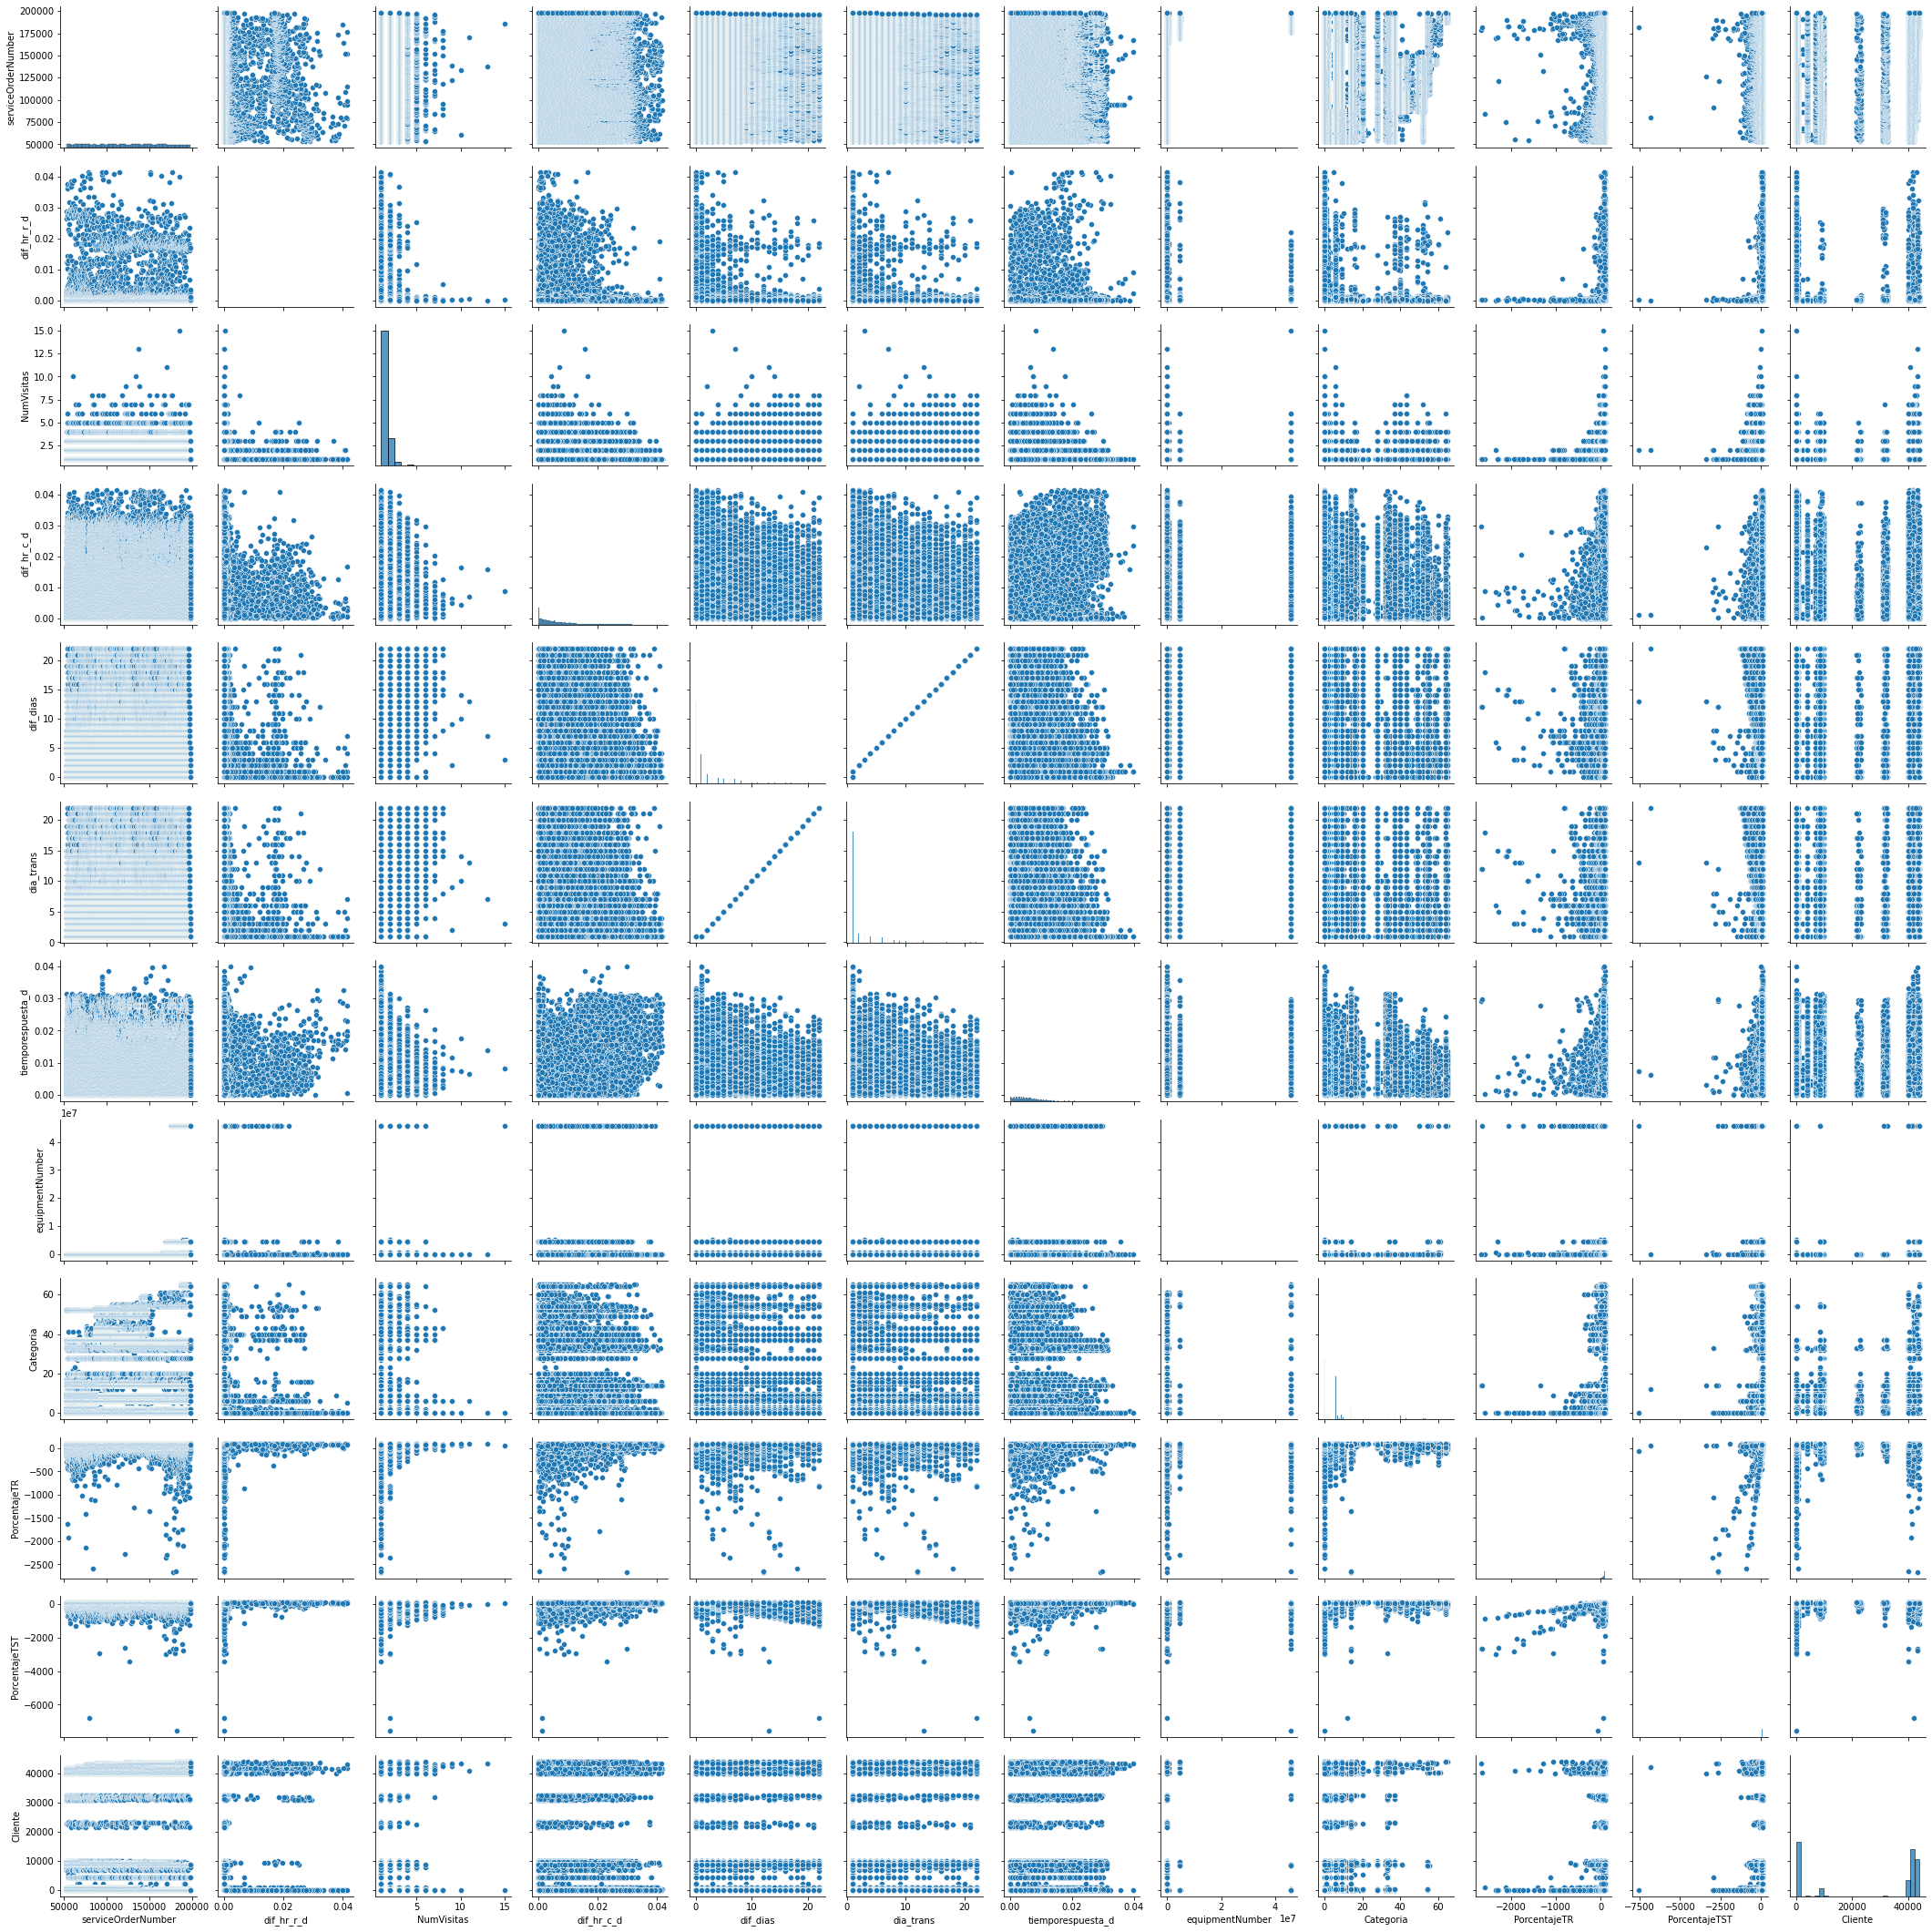

In [37]:
sns.pairplot(Procesos_resueltos_22)

## Matriz de Covarianza por Region

### Covarianza Region Norte

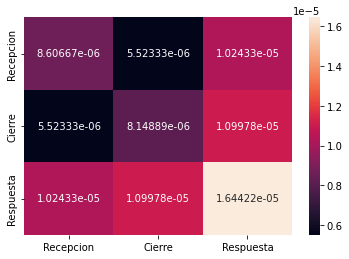

In [38]:
cov = np.cov(Procesos_resueltos_22_N.iloc[[29,31,32], [4,13,19]], bias=True)
labs = ['Recepcion', 'Cierre', 'Respuesta']

sns.heatmap (cov, annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs)
plt.show ()

### Covarianza Region Noroeste

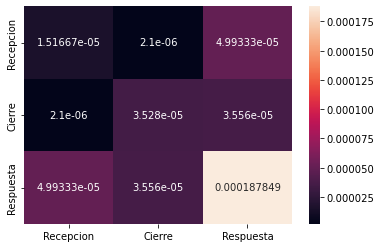

In [39]:
cov = np.cov(Procesos_resueltos_22_NO.iloc[[29,31,32], [4,13,19]], bias=True)
labs = ['Recepcion', 'Cierre', 'Respuesta']

sns.heatmap (cov, annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs)
plt.show ()

### Covarianza Region Noreste

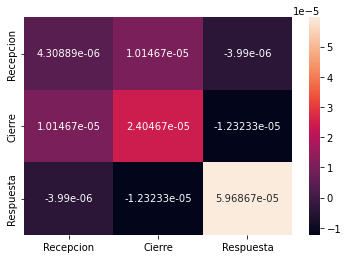

In [40]:
cov = np.cov(Procesos_resueltos_22_NE.iloc[[29,31,32], [4,13,19]], bias=True)
labs = ['Recepcion', 'Cierre', 'Respuesta']

sns.heatmap (cov, annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs)
plt.show ()

### Covarianza Region Centro Occidente

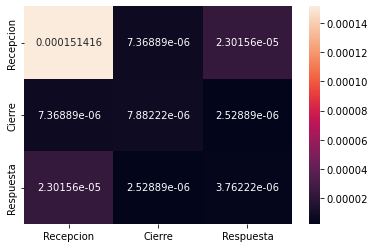

In [41]:
cov = np.cov(Procesos_resueltos_22_CO.iloc[[29,31,32], [4,13,19]], bias=True)
labs = ['Recepcion', 'Cierre', 'Respuesta']

sns.heatmap (cov, annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs)
plt.show ()

### Covarianza Region Centro Este

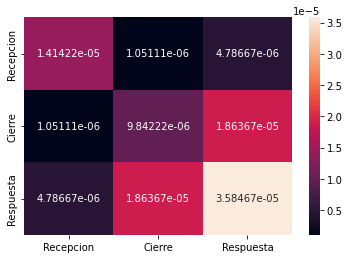

In [42]:
cov = np.cov(Procesos_resueltos_22_CE.iloc[[29,31,32], [4,13,19]], bias=True)
labs = ['Recepcion', 'Cierre', 'Respuesta']

sns.heatmap (cov, annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs)
plt.show ()

### Covarianza Region Oriente

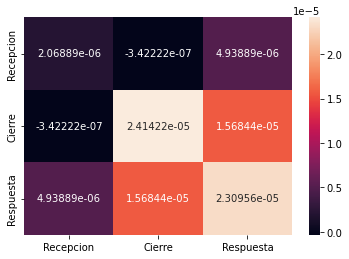

In [43]:
cov = np.cov(Procesos_resueltos_22_OR.iloc[[29,31,32], [4,13,19]], bias=True)
labs = ['Recepcion', 'Cierre', 'Respuesta']

sns.heatmap (cov, annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs)
plt.show ()

### Covarianza Region Sur

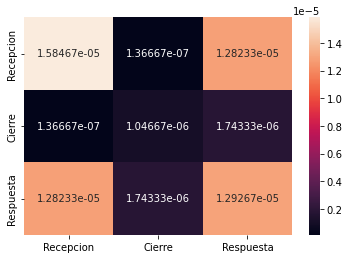

In [44]:
cov = np.cov(Procesos_resueltos_22_S.iloc[[29,31,32], [4,13,19]], bias=True)
labs = ['Recepcion', 'Cierre', 'Respuesta']

sns.heatmap (cov, annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs)
plt.show ()

### Covarianza Yucatán 

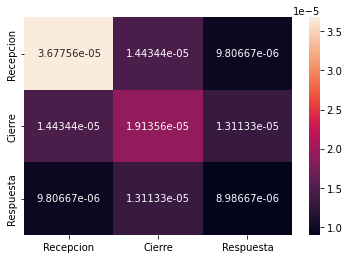

In [45]:
cov = np.cov(Procesos_resueltos_22_Y.iloc[[29,31,32], [4,13,19]], bias=True)
labs = ['Recepcion', 'Cierre', 'Respuesta']

sns.heatmap (cov, annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs)
plt.show ()

## Gráfica de Tiempo de Respuesta vs. Tiempo de Recepcion vs. Tiempo de Cierre por Region

### Norte

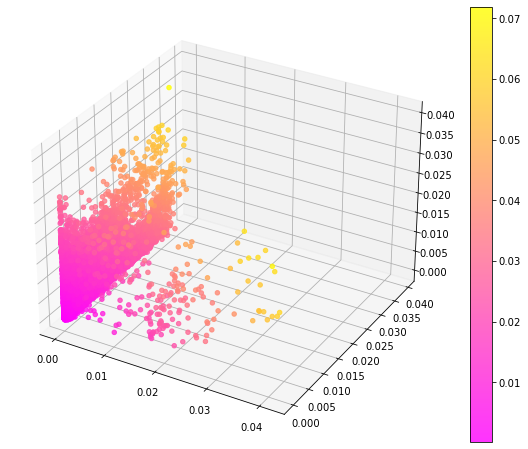

In [46]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('spring')
fg= ax.scatter3D(Procesos_resueltos_22_N['dif_hr_r_d'],Procesos_resueltos_22_N['dif_hr_c_d'],Procesos_resueltos_22_N['tiemporespuesta_d'],
                 c=(Procesos_resueltos_22_N['dif_hr_r_d']+Procesos_resueltos_22_N['dif_hr_c_d']+Procesos_resueltos_22_N['tiemporespuesta_d']),
                 cmap = color_map,
                 alpha=.8
                )
plt.colorbar(fg)
plt.show()

### Noroeste

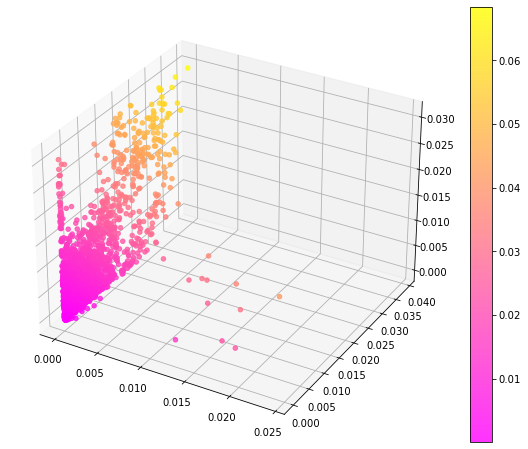

In [47]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('spring')
fg= ax.scatter3D(Procesos_resueltos_22_NO['dif_hr_r_d'],Procesos_resueltos_22_NO['dif_hr_c_d'],Procesos_resueltos_22_NO['tiemporespuesta_d'],
                 c=(Procesos_resueltos_22_NO['dif_hr_r_d']+Procesos_resueltos_22_NO['dif_hr_c_d']+Procesos_resueltos_22_NO['tiemporespuesta_d']),
                 cmap = color_map,
                 alpha=.8
                )
plt.colorbar(fg)
plt.show()

### Noreste

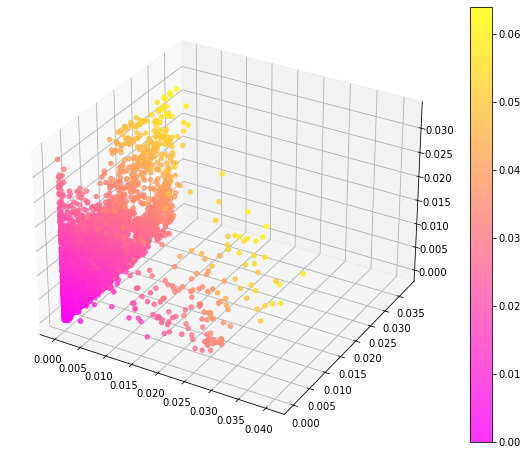

In [48]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('spring')
fg= ax.scatter3D(Procesos_resueltos_22_NE['dif_hr_r_d'],Procesos_resueltos_22_NE['dif_hr_c_d'],Procesos_resueltos_22_NE['tiemporespuesta_d'],
                 c=(Procesos_resueltos_22_NE['dif_hr_r_d']+Procesos_resueltos_22_NE['dif_hr_c_d']+Procesos_resueltos_22_NE['tiemporespuesta_d']),
                 cmap = color_map,
                 alpha=.8
                )
plt.colorbar(fg)
plt.show()

### Centro Occidente

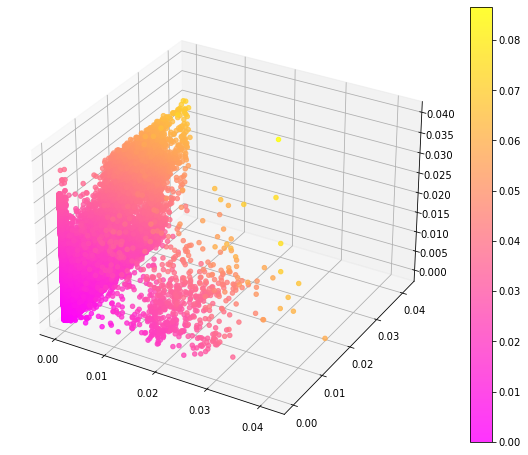

In [49]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('spring')
fg= ax.scatter3D(Procesos_resueltos_22_CO['dif_hr_r_d'],Procesos_resueltos_22_CO['dif_hr_c_d'],Procesos_resueltos_22_CO['tiemporespuesta_d'],
                 c=(Procesos_resueltos_22_CO['dif_hr_r_d']+Procesos_resueltos_22_CO['dif_hr_c_d']+Procesos_resueltos_22_CO['tiemporespuesta_d']),
                 cmap = color_map,
                 alpha=.8
                )
plt.colorbar(fg)
plt.show()

### Centro Este

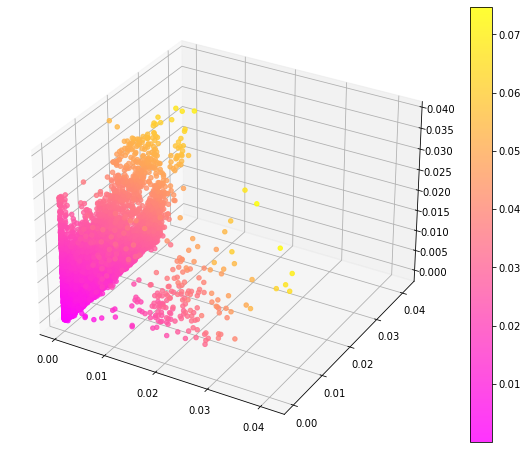

In [50]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('spring')
fg= ax.scatter3D(Procesos_resueltos_22_CE['dif_hr_r_d'],Procesos_resueltos_22_CE['dif_hr_c_d'],Procesos_resueltos_22_CE['tiemporespuesta_d'],
                 c=(Procesos_resueltos_22_CE['dif_hr_r_d']+Procesos_resueltos_22_CE['dif_hr_c_d']+Procesos_resueltos_22_CE['tiemporespuesta_d']),
                 cmap = color_map,
                 alpha=.8
                )
plt.colorbar(fg)
plt.show()

### Oriente

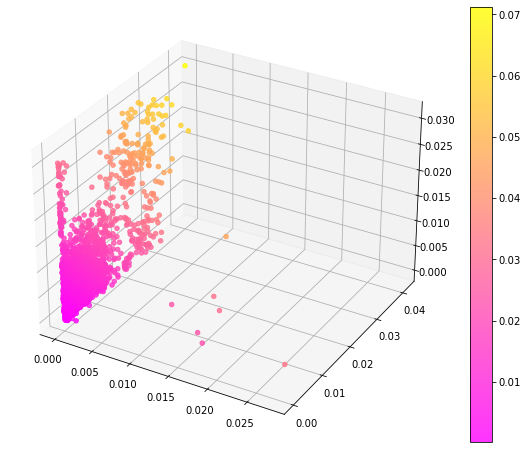

In [51]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('spring')
fg= ax.scatter3D(Procesos_resueltos_22_OR['dif_hr_r_d'],Procesos_resueltos_22_OR['dif_hr_c_d'],Procesos_resueltos_22_OR['tiemporespuesta_d'],
                 c=(Procesos_resueltos_22_OR['dif_hr_r_d']+Procesos_resueltos_22_OR['dif_hr_c_d']+Procesos_resueltos_22_OR['tiemporespuesta_d']),
                 cmap = color_map,
                 alpha=.8
                )
plt.colorbar(fg)
plt.show()

### Sur

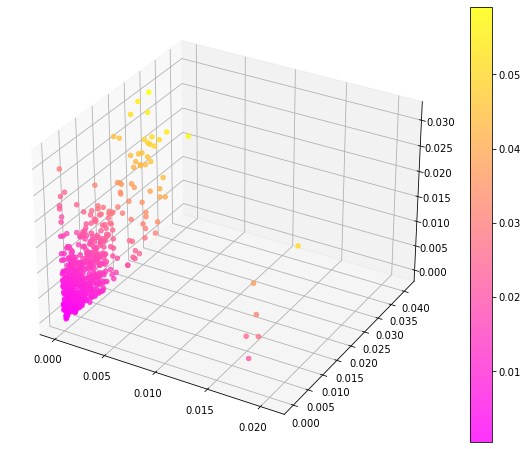

In [52]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('spring')
fg= ax.scatter3D(Procesos_resueltos_22_S['dif_hr_r_d'],Procesos_resueltos_22_S['dif_hr_c_d'],Procesos_resueltos_22_S['tiemporespuesta_d'],
                 c=(Procesos_resueltos_22_S['dif_hr_r_d']+Procesos_resueltos_22_S['dif_hr_c_d']+Procesos_resueltos_22_S['tiemporespuesta_d']),
                 cmap = color_map,
                 alpha=.8
                )
plt.colorbar(fg)
plt.show()

### Yucatán

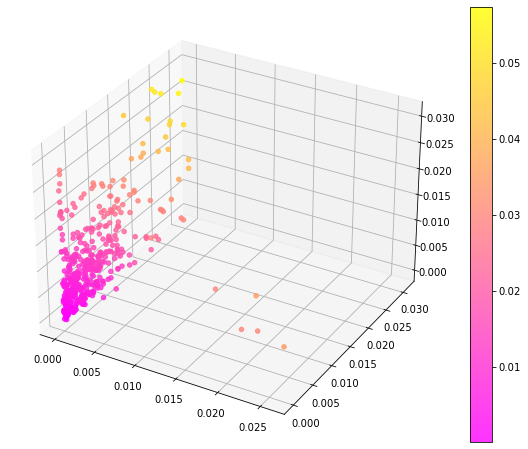

In [53]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('spring')
fg= ax.scatter3D(Procesos_resueltos_22_Y['dif_hr_r_d'],Procesos_resueltos_22_Y['dif_hr_c_d'],Procesos_resueltos_22_Y['tiemporespuesta_d'],
                 c=(Procesos_resueltos_22_Y['dif_hr_r_d']+Procesos_resueltos_22_Y['dif_hr_c_d']+Procesos_resueltos_22_Y['tiemporespuesta_d']),
                 cmap = color_map,
                 alpha=.8
                )
plt.colorbar(fg)
plt.show()

## Análisis de Correlación por región

### Correlación de Pearson
- En estadística, el coeficiente de correlación de Pearson es una medida de dependencia lineal entre dos variables aleatorias cuantitativas. A diferencia de la covarianza, la correlación de Pearson es independiente de la escala de medida de las variables.

### Correlación Norte

In [54]:
corr_matrix_N = Procesos_resueltos_22_N.corr(method='pearson')
corr_matrix_N

serviceOrderNumber  dif_hr_r_d  NumVisitas  dif_hr_c_d  \
serviceOrderNumber            1.000000   -0.040321   -0.031445   -0.072372   
dif_hr_r_d                   -0.040321    1.000000   -0.003027   -0.006722   
NumVisitas                   -0.031445   -0.003027    1.000000    0.076781   
dif_hr_c_d                   -0.072372   -0.006722    0.076781    1.000000   
dif_dias                      0.092706   -0.004830    0.517445    0.046275   
dia_trans                     0.103249   -0.006788    0.484571    0.037307   
tiemporespuesta_d            -0.066526    0.124328    0.057350    0.167608   
equipmentNumber               0.268715   -0.001143   -0.005150   -0.005694   
Categoria                    -0.118942    0.006720    0.059603    0.053756   
PorcentajeTR                 -0.008456    0.003182   -0.048690   -0.026339   
PorcentajeTST                -0.050463    0.009714   -0.454149   -0.055575   
Cliente                      -0.138391   -0.017987   -0.042291    0.004114   

                    dif_dias  dia_trans  tiemporespuesta_d  equipmentNumber  \
serviceOrderNumber  0.092706   0.103249          -0.066526         0.268715   
dif_hr_r_d         -0.004830  -0.006788           0.124328        -0.001143   
NumVisitas          0.517445   0.484571           0.057350        -0.005150   
dif_hr_c_d          0.046275   0.037307           0.167608        -0.005694   
dif_dias            1.000000   0.993710           0.100500         0.096711   
dia_trans           0.993710   1.000000           0.072385         0.088836   
tiemporespuesta_d   0.100500   0.072385           1.000000         0.049045   
equipmentNumber     0.096711   0.088836           0.049045         1.000000   
Categoria          -0.011360  -0.014520           0.037396        -0.025052   
PorcentajeTR       -0.038900  -0.029637          -0.077899        -0.025019   
PorcentajeTST      -0.402679  -0.395301          -0.075981        -0.002202   
Cliente            -0.048135  -0.036845          -0.093897        -0.143503   

                    Categoria  PorcentajeTR  PorcentajeTST   Cliente  
serviceOrderNumber  -0.118942     -0.008456      -0.050463 -0.138391  
dif_hr_r_d           0.006720      0.003182       0.009714 -0.017987  
NumVisitas           0.059603     -0.048690      -0.454149 -0.042291  
dif_hr_c_d           0.053756     -0.026339      -0.055575  0.004114  
dif_dias            -0.011360     -0.038900      -0.402679 -0.048135  
dia_trans           -0.014520     -0.029637      -0.395301 -0.036845  
tiemporespuesta_d    0.037396     -0.077899      -0.075981 -0.093897  
equipmentNumber     -0.025052     -0.025019      -0.002202 -0.143503  
Categoria            1.000000     -0.047145      -0.056437  0.501584  
PorcentajeTR        -0.047145      1.000000       0.368868  0.077486  
PorcentajeTST       -0.056437      0.368868       1.000000  0.030778  
Cliente              0.501584      0.077486       0.030778  1.000000

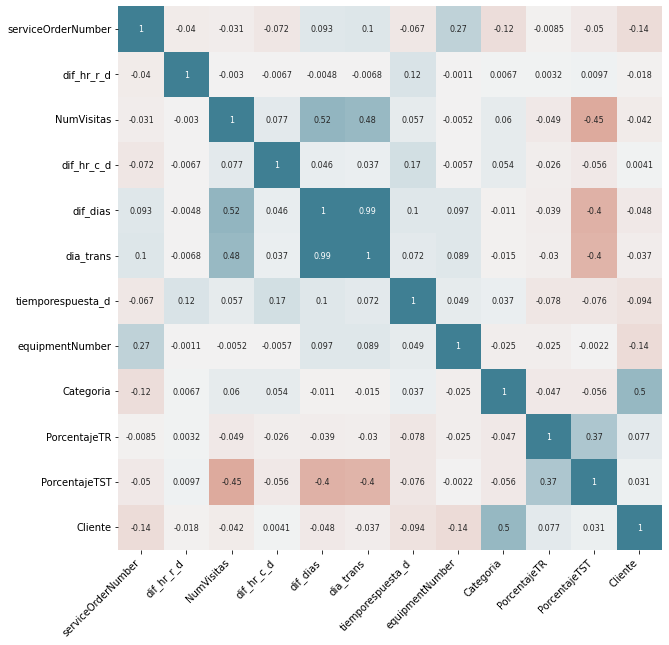

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix_N,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

### Correlación Noroeste

In [56]:
corr_matrix_NO = Procesos_resueltos_22_NO.corr(method='pearson')
corr_matrix_NO

serviceOrderNumber  dif_hr_r_d  NumVisitas  dif_hr_c_d  \
serviceOrderNumber            1.000000    0.055540    0.205976   -0.123516   
dif_hr_r_d                    0.055540    1.000000    0.032518   -0.025796   
NumVisitas                    0.205976    0.032518    1.000000   -0.022373   
dif_hr_c_d                   -0.123516   -0.025796   -0.022373    1.000000   
dif_dias                      0.122746    0.034355    0.403878   -0.058168   
dia_trans                     0.111939    0.031295    0.396374   -0.043538   
tiemporespuesta_d            -0.068883    0.000331   -0.065225    0.446754   
equipmentNumber               0.396811    0.049513   -0.024781   -0.033159   
Categoria                     0.038536   -0.009684    0.256692    0.135547   
PorcentajeTR                 -0.049443    0.006706   -0.076325   -0.007709   
PorcentajeTST                -0.061996    0.008149   -0.285895   -0.033353   
Cliente                      -0.149829   -0.034575    0.049845   -0.007024   

                    dif_dias  dia_trans  tiemporespuesta_d  equipmentNumber  \
serviceOrderNumber  0.122746   0.111939          -0.068883         0.396811   
dif_hr_r_d          0.034355   0.031295           0.000331         0.049513   
NumVisitas          0.403878   0.396374          -0.065225        -0.024781   
dif_hr_c_d         -0.058168  -0.043538           0.446754        -0.033159   
dif_dias            1.000000   0.997021          -0.088846         0.030405   
dia_trans           0.997021   1.000000          -0.071649         0.020643   
tiemporespuesta_d  -0.088846  -0.071649           1.000000        -0.012887   
equipmentNumber     0.030405   0.020643          -0.012887         1.000000   
Categoria          -0.105034  -0.092394           0.130683        -0.191071   
PorcentajeTR       -0.032237  -0.029374          -0.057164         0.019329   
PorcentajeTST      -0.210734  -0.216801          -0.059638        -0.001228   
Cliente            -0.103964  -0.094523           0.055223        -0.340757   

                    Categoria  PorcentajeTR  PorcentajeTST   Cliente  
serviceOrderNumber   0.038536     -0.049443      -0.061996 -0.149829  
dif_hr_r_d          -0.009684      0.006706       0.008149 -0.034575  
NumVisitas           0.256692     -0.076325      -0.285895  0.049845  
dif_hr_c_d           0.135547     -0.007709      -0.033353 -0.007024  
dif_dias            -0.105034     -0.032237      -0.210734 -0.103964  
dia_trans           -0.092394     -0.029374      -0.216801 -0.094523  
tiemporespuesta_d    0.130683     -0.057164      -0.059638  0.055223  
equipmentNumber     -0.191071      0.019329      -0.001228 -0.340757  
Categoria            1.000000     -0.112031      -0.192401  0.497544  
PorcentajeTR        -0.112031      1.000000       0.548703  0.043752  
PorcentajeTST       -0.192401      0.548703       1.000000 -0.045429  
Cliente              0.497544      0.043752      -0.045429  1.000000

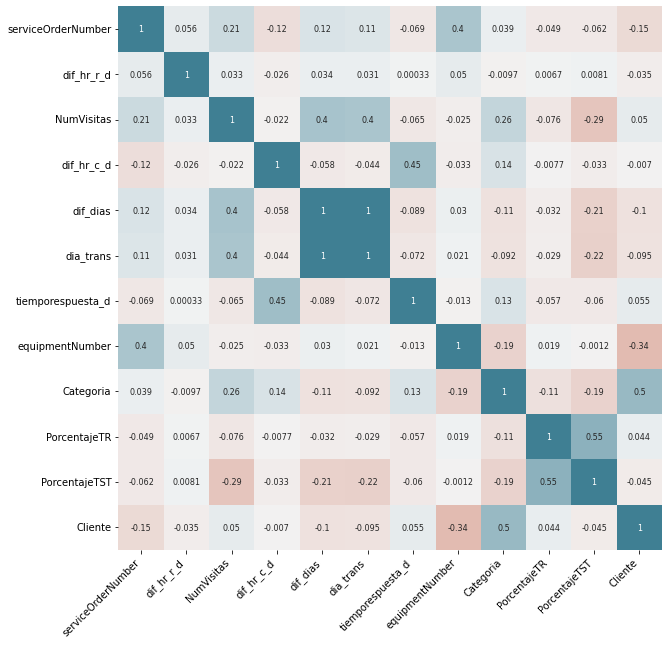

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix_NO,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

### Correlación Noreste

In [58]:
corr_matrix_NE = Procesos_resueltos_22_NE.corr(method='pearson')
corr_matrix_NE

serviceOrderNumber  dif_hr_r_d  NumVisitas  dif_hr_c_d  \
serviceOrderNumber            1.000000   -0.079734    0.035284   -0.032058   
dif_hr_r_d                   -0.079734    1.000000   -0.029328   -0.001257   
NumVisitas                    0.035284   -0.029328    1.000000    0.011322   
dif_hr_c_d                   -0.032058   -0.001257    0.011322    1.000000   
dif_dias                      0.100063   -0.040040    0.422405   -0.020094   
dia_trans                     0.096879   -0.035419    0.401771   -0.020304   
tiemporespuesta_d            -0.048596    0.072092   -0.081011    0.163741   
equipmentNumber               0.324625   -0.011312    0.020675    0.002550   
Categoria                    -0.085507   -0.030512    0.041882    0.052893   
PorcentajeTR                 -0.051245    0.036686   -0.031797   -0.024121   
PorcentajeTST                -0.059728    0.029544   -0.394019   -0.034661   
Cliente                      -0.074349   -0.010561   -0.060204    0.041272   

                    dif_dias  dia_trans  tiemporespuesta_d  equipmentNumber  \
serviceOrderNumber  0.100063   0.096879          -0.048596         0.324625   
dif_hr_r_d         -0.040040  -0.035419           0.072092        -0.011312   
NumVisitas          0.422405   0.401771          -0.081011         0.020675   
dif_hr_c_d         -0.020094  -0.020304           0.163741         0.002550   
dif_dias            1.000000   0.994081          -0.055779         0.049564   
dia_trans           0.994081   1.000000          -0.064283         0.043948   
tiemporespuesta_d  -0.055779  -0.064283           1.000000        -0.001862   
equipmentNumber     0.049564   0.043948          -0.001862         1.000000   
Categoria          -0.083244  -0.078173           0.016062        -0.086573   
PorcentajeTR        0.014299   0.012547          -0.028405        -0.060200   
PorcentajeTST      -0.255013  -0.252400          -0.005893        -0.044396   
Cliente            -0.019539  -0.013885           0.003606        -0.203152   

                    Categoria  PorcentajeTR  PorcentajeTST   Cliente  
serviceOrderNumber  -0.085507     -0.051245      -0.059728 -0.074349  
dif_hr_r_d          -0.030512      0.036686       0.029544 -0.010561  
NumVisitas           0.041882     -0.031797      -0.394019 -0.060204  
dif_hr_c_d           0.052893     -0.024121      -0.034661  0.041272  
dif_dias            -0.083244      0.014299      -0.255013 -0.019539  
dia_trans           -0.078173      0.012547      -0.252400 -0.013885  
tiemporespuesta_d    0.016062     -0.028405      -0.005893  0.003606  
equipmentNumber     -0.086573     -0.060200      -0.044396 -0.203152  
Categoria            1.000000     -0.029732      -0.035992  0.505002  
PorcentajeTR        -0.029732      1.000000       0.523927  0.069009  
PorcentajeTST       -0.035992      0.523927       1.000000  0.026391  
Cliente              0.505002      0.069009       0.026391  1.000000

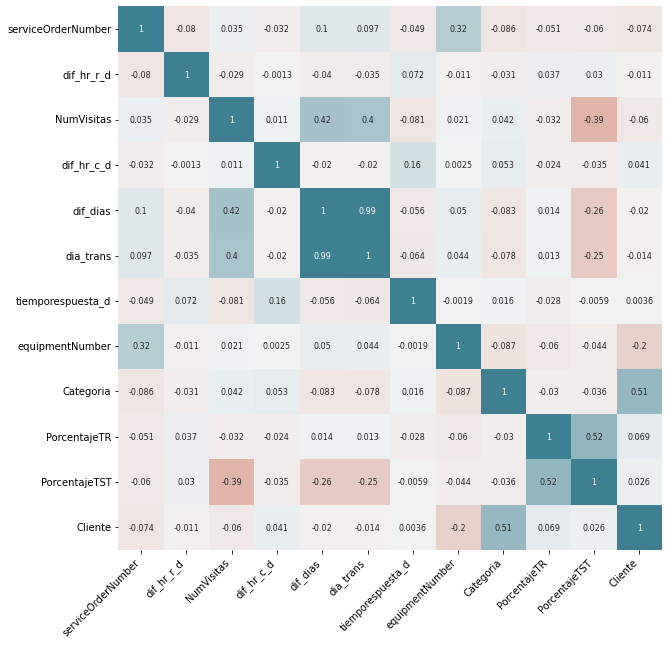

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix_NE,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

### Correlación Centro Occidente

In [60]:
corr_matrix_Occ = Procesos_resueltos_22_CO.corr(method='pearson')
corr_matrix_Occ

serviceOrderNumber  dif_hr_r_d  NumVisitas  dif_hr_c_d  \
serviceOrderNumber            1.000000    0.036785    0.043662   -0.059807   
dif_hr_r_d                    0.036785    1.000000    0.006599    0.000802   
NumVisitas                    0.043662    0.006599    1.000000   -0.025252   
dif_hr_c_d                   -0.059807    0.000802   -0.025252    1.000000   
dif_dias                      0.007946   -0.027070    0.409516   -0.068670   
dia_trans                     0.007374   -0.025136    0.392296   -0.060981   
tiemporespuesta_d            -0.004108    0.000868   -0.096520    0.317592   
equipmentNumber               0.214705   -0.004064    0.021282   -0.008788   
Categoria                    -0.019393   -0.026288    0.033162    0.116898   
PorcentajeTR                  0.010965    0.024394   -0.056114   -0.053868   
PorcentajeTST                -0.017897    0.012175   -0.381699   -0.037804   
Cliente                       0.210296    0.037132   -0.052013   -0.022095   

                    dif_dias  dia_trans  tiemporespuesta_d  equipmentNumber  \
serviceOrderNumber  0.007946   0.007374          -0.004108         0.214705   
dif_hr_r_d         -0.027070  -0.025136           0.000868        -0.004064   
NumVisitas          0.409516   0.392296          -0.096520         0.021282   
dif_hr_c_d         -0.068670  -0.060981           0.317592        -0.008788   
dif_dias            1.000000   0.994449          -0.121807         0.040745   
dia_trans           0.994449   1.000000          -0.109473         0.033976   
tiemporespuesta_d  -0.121807  -0.109473           1.000000        -0.011100   
equipmentNumber     0.040745   0.033976          -0.011100         1.000000   
Categoria          -0.068826  -0.062539           0.216207         0.049041   
PorcentajeTR       -0.027821  -0.024270          -0.099794        -0.034457   
PorcentajeTST      -0.302129  -0.301472          -0.046354        -0.030715   
Cliente            -0.067667  -0.059663          -0.035563        -0.028752   

                    Categoria  PorcentajeTR  PorcentajeTST   Cliente  
serviceOrderNumber  -0.019393      0.010965      -0.017897  0.210296  
dif_hr_r_d          -0.026288      0.024394       0.012175  0.037132  
NumVisitas           0.033162     -0.056114      -0.381699 -0.052013  
dif_hr_c_d           0.116898     -0.053868      -0.037804 -0.022095  
dif_dias            -0.068826     -0.027821      -0.302129 -0.067667  
dia_trans           -0.062539     -0.024270      -0.301472 -0.059663  
tiemporespuesta_d    0.216207     -0.099794      -0.046354 -0.035563  
equipmentNumber      0.049041     -0.034457      -0.030715 -0.028752  
Categoria            1.000000     -0.087813      -0.055207  0.154212  
PorcentajeTR        -0.087813      1.000000       0.481150  0.102643  
PorcentajeTST       -0.055207      0.481150       1.000000  0.080334  
Cliente              0.154212      0.102643       0.080334  1.000000

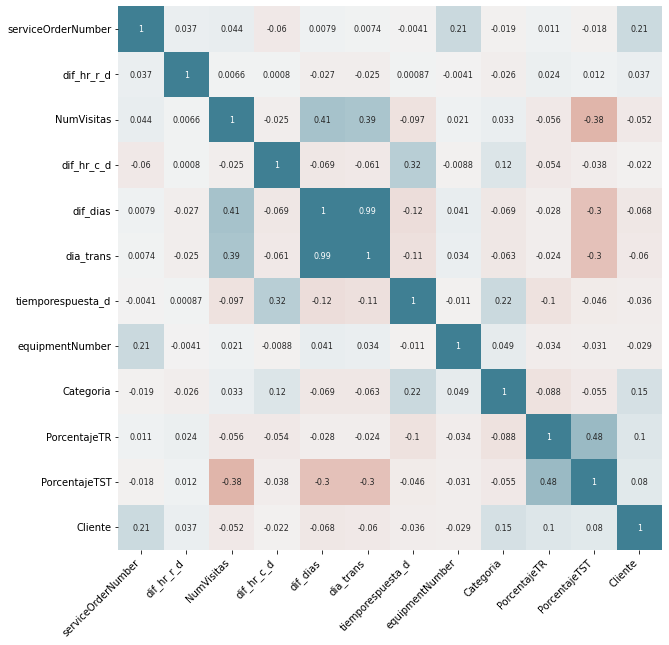

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix_Occ,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

### Correlación Centro Este

In [62]:
corr_matrix_CE = Procesos_resueltos_22_CE.corr(method='pearson')
corr_matrix_CE

serviceOrderNumber  dif_hr_r_d  NumVisitas  dif_hr_c_d  \
serviceOrderNumber            1.000000    0.011979    0.013158   -0.049548   
dif_hr_r_d                    0.011979    1.000000    0.000510   -0.000490   
NumVisitas                    0.013158    0.000510    1.000000    0.040141   
dif_hr_c_d                   -0.049548   -0.000490    0.040141    1.000000   
dif_dias                      0.016581   -0.010620    0.531761    0.015374   
dia_trans                     0.014522   -0.008168    0.517179    0.015272   
tiemporespuesta_d             0.006750    0.074779   -0.072341    0.183344   
equipmentNumber               0.374153   -0.005907   -0.036320   -0.005026   
Categoria                    -0.117690    0.003372    0.045218    0.044737   
PorcentajeTR                 -0.085190   -0.006334   -0.054575   -0.039190   
PorcentajeTST                -0.041856    0.003966   -0.364359   -0.042442   
Cliente                      -0.446098   -0.017283    0.028977    0.009650   

                    dif_dias  dia_trans  tiemporespuesta_d  equipmentNumber  \
serviceOrderNumber  0.016581   0.014522           0.006750         0.374153   
dif_hr_r_d         -0.010620  -0.008168           0.074779        -0.005907   
NumVisitas          0.531761   0.517179          -0.072341        -0.036320   
dif_hr_c_d          0.015374   0.015272           0.183344        -0.005026   
dif_dias            1.000000   0.995603          -0.065487        -0.000565   
dia_trans           0.995603   1.000000          -0.066785        -0.005231   
tiemporespuesta_d  -0.065487  -0.066785           1.000000        -0.009588   
equipmentNumber    -0.000565  -0.005231          -0.009588         1.000000   
Categoria          -0.027865  -0.024696           0.028630        -0.056848   
PorcentajeTR        0.012706   0.011140          -0.078004        -0.002342   
PorcentajeTST      -0.326221  -0.327715          -0.022460         0.006043   
Cliente             0.032643   0.039302          -0.049458        -0.260481   

                    Categoria  PorcentajeTR  PorcentajeTST   Cliente  
serviceOrderNumber  -0.117690     -0.085190      -0.041856 -0.446098  
dif_hr_r_d           0.003372     -0.006334       0.003966 -0.017283  
NumVisitas           0.045218     -0.054575      -0.364359  0.028977  
dif_hr_c_d           0.044737     -0.039190      -0.042442  0.009650  
dif_dias            -0.027865      0.012706      -0.326221  0.032643  
dia_trans           -0.024696      0.011140      -0.327715  0.039302  
tiemporespuesta_d    0.028630     -0.078004      -0.022460 -0.049458  
equipmentNumber     -0.056848     -0.002342       0.006043 -0.260481  
Categoria            1.000000     -0.014496       0.015515  0.407216  
PorcentajeTR        -0.014496      1.000000       0.354140  0.105599  
PorcentajeTST        0.015515      0.354140       1.000000  0.034097  
Cliente              0.407216      0.105599       0.034097  1.000000

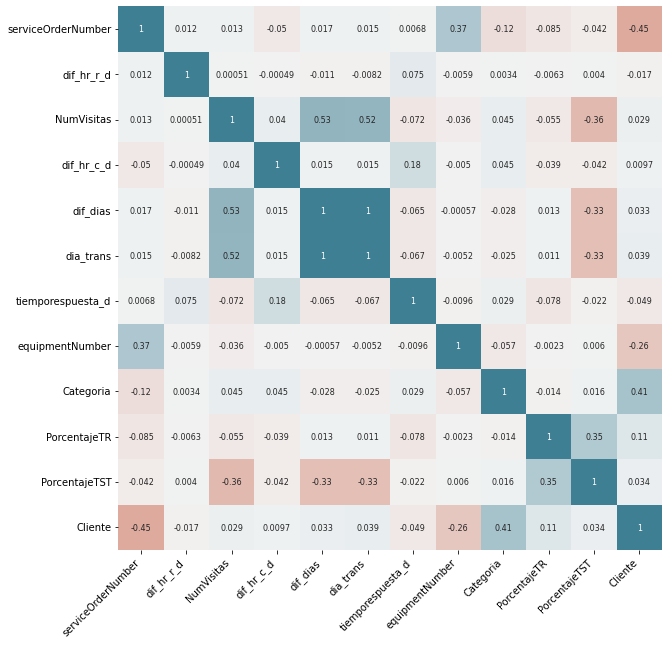

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix_CE,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

### Correlación Oriente

In [64]:
corr_matrix_OR = Procesos_resueltos_22_OR.corr(method='pearson')
corr_matrix_OR

serviceOrderNumber  dif_hr_r_d  NumVisitas  dif_hr_c_d  \
serviceOrderNumber            1.000000    0.044411    0.101716   -0.116631   
dif_hr_r_d                    0.044411    1.000000    0.010664   -0.012462   
NumVisitas                    0.101716    0.010664    1.000000    0.035493   
dif_hr_c_d                   -0.116631   -0.012462    0.035493    1.000000   
dif_dias                     -0.013512   -0.015036    0.451578   -0.044041   
dia_trans                    -0.015393   -0.012280    0.439315   -0.036233   
tiemporespuesta_d            -0.152715   -0.001838   -0.083512    0.344206   
equipmentNumber               0.314373    0.013017    0.014723   -0.032036   
Categoria                    -0.223999   -0.046600    0.079782    0.127305   
PorcentajeTR                 -0.064197    0.019924   -0.036190   -0.046473   
PorcentajeTST                -0.081341   -0.016967   -0.262125   -0.046172   
Cliente                      -0.440888   -0.060311   -0.093802    0.069202   

                    dif_dias  dia_trans  tiemporespuesta_d  equipmentNumber  \
serviceOrderNumber -0.013512  -0.015393          -0.152715         0.314373   
dif_hr_r_d         -0.015036  -0.012280          -0.001838         0.013017   
NumVisitas          0.451578   0.439315          -0.083512         0.014723   
dif_hr_c_d         -0.044041  -0.036233           0.344206        -0.032036   
dif_dias            1.000000   0.995268          -0.159395        -0.024841   
dia_trans           0.995268   1.000000          -0.138088        -0.028878   
tiemporespuesta_d  -0.159395  -0.138088           1.000000        -0.107272   
equipmentNumber    -0.024841  -0.028878          -0.107272         1.000000   
Categoria           0.022146   0.026828           0.177072        -0.286417   
PorcentajeTR        0.024561   0.030620          -0.035864        -0.095041   
PorcentajeTST      -0.189013  -0.189057          -0.031858        -0.083965   
Cliente             0.089325   0.089097           0.121505        -0.351723   

                    Categoria  PorcentajeTR  PorcentajeTST   Cliente  
serviceOrderNumber  -0.223999     -0.064197      -0.081341 -0.440888  
dif_hr_r_d          -0.046600      0.019924      -0.016967 -0.060311  
NumVisitas           0.079782     -0.036190      -0.262125 -0.093802  
dif_hr_c_d           0.127305     -0.046473      -0.046172  0.069202  
dif_dias             0.022146      0.024561      -0.189013  0.089325  
dia_trans            0.026828      0.030620      -0.189057  0.089097  
tiemporespuesta_d    0.177072     -0.035864      -0.031858  0.121505  
equipmentNumber     -0.286417     -0.095041      -0.083965 -0.351723  
Categoria            1.000000     -0.062698      -0.046306  0.592492  
PorcentajeTR        -0.062698      1.000000       0.739508  0.040418  
PorcentajeTST       -0.046306      0.739508       1.000000  0.047199  
Cliente              0.592492      0.040418       0.047199  1.000000

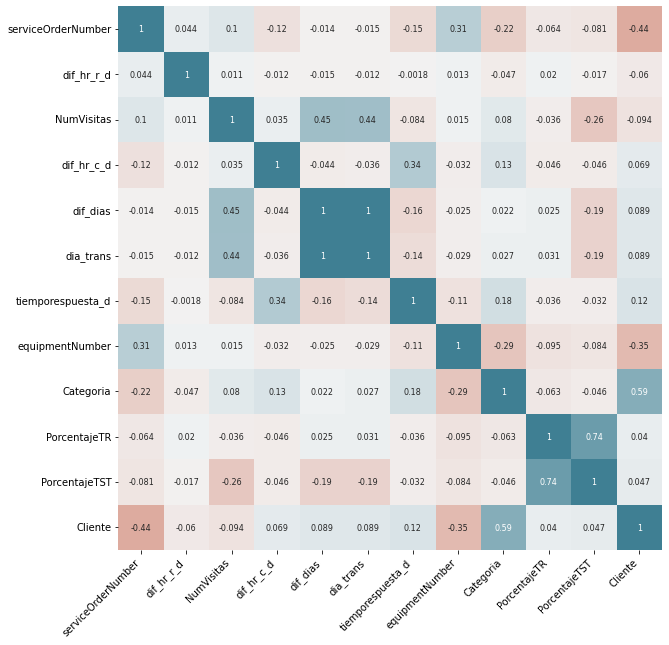

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix_OR,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

### Correlación Sur

In [66]:
corr_matrix_S = Procesos_resueltos_22_S.corr(method='pearson')
corr_matrix_S

serviceOrderNumber  dif_hr_r_d  NumVisitas  dif_hr_c_d  \
serviceOrderNumber            1.000000    0.096679    0.146036   -0.183228   
dif_hr_r_d                    0.096679    1.000000   -0.004686   -0.050194   
NumVisitas                    0.146036   -0.004686    1.000000   -0.004947   
dif_hr_c_d                   -0.183228   -0.050194   -0.004947    1.000000   
dif_dias                      0.059202   -0.045951    0.459251   -0.085523   
dia_trans                     0.055913   -0.042953    0.453867   -0.077946   
tiemporespuesta_d            -0.173197    0.078414   -0.062580    0.381046   
equipmentNumber               0.293657    0.039285    0.090986   -0.015989   
Categoria                    -0.326997   -0.076036    0.050443    0.205987   
PorcentajeTR                  0.043438    0.020452   -0.052180   -0.083280   
PorcentajeTST                -0.130702    0.030366   -0.412821   -0.051284   
Cliente                      -0.372431   -0.065962   -0.104184    0.115703   

                    dif_dias  dia_trans  tiemporespuesta_d  equipmentNumber  \
serviceOrderNumber  0.059202   0.055913          -0.173197         0.293657   
dif_hr_r_d         -0.045951  -0.042953           0.078414         0.039285   
NumVisitas          0.459251   0.453867          -0.062580         0.090986   
dif_hr_c_d         -0.085523  -0.077946           0.381046        -0.015989   
dif_dias            1.000000   0.997139          -0.102000         0.006703   
dia_trans           0.997139   1.000000          -0.087480         0.003563   
tiemporespuesta_d  -0.102000  -0.087480           1.000000        -0.001594   
equipmentNumber     0.006703   0.003563          -0.001594         1.000000   
Categoria          -0.095813  -0.085961           0.126585        -0.178972   
PorcentajeTR        0.032812   0.038215           0.042851        -0.018796   
PorcentajeTST      -0.353361  -0.355053           0.031890        -0.081249   
Cliente            -0.009656  -0.002379           0.169126        -0.248850   

                    Categoria  PorcentajeTR  PorcentajeTST   Cliente  
serviceOrderNumber  -0.326997      0.043438      -0.130702 -0.372431  
dif_hr_r_d          -0.076036      0.020452       0.030366 -0.065962  
NumVisitas           0.050443     -0.052180      -0.412821 -0.104184  
dif_hr_c_d           0.205987     -0.083280      -0.051284  0.115703  
dif_dias            -0.095813      0.032812      -0.353361 -0.009656  
dia_trans           -0.085961      0.038215      -0.355053 -0.002379  
tiemporespuesta_d    0.126585      0.042851       0.031890  0.169126  
equipmentNumber     -0.178972     -0.018796      -0.081249 -0.248850  
Categoria            1.000000     -0.058922       0.048236  0.659749  
PorcentajeTR        -0.058922      1.000000       0.274156  0.091183  
PorcentajeTST        0.048236      0.274156       1.000000  0.139489  
Cliente              0.659749      0.091183       0.139489  1.000000

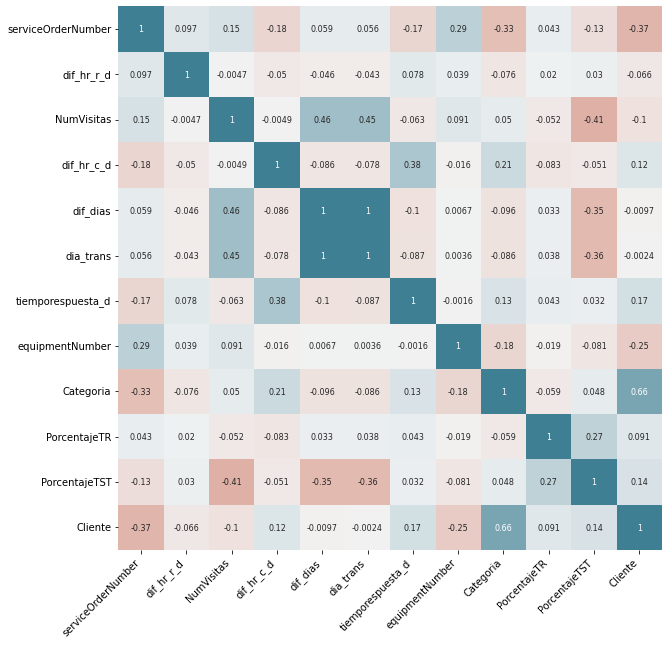

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix_S,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

### Correlación Yucatán

In [68]:
corr_matrix_Y = Procesos_resueltos_22_Y.corr(method='pearson')
corr_matrix_Y

serviceOrderNumber  dif_hr_r_d  NumVisitas  dif_hr_c_d  \
serviceOrderNumber            1.000000    0.002059    0.091335   -0.071860   
dif_hr_r_d                    0.002059    1.000000   -0.039465   -0.017347   
NumVisitas                    0.091335   -0.039465    1.000000    0.018563   
dif_hr_c_d                   -0.071860   -0.017347    0.018563    1.000000   
dif_dias                      0.127808   -0.053847    0.319010   -0.070753   
dia_trans                     0.120174   -0.046563    0.313173   -0.064652   
tiemporespuesta_d            -0.044933   -0.022119   -0.109262    0.293704   
equipmentNumber               0.235009   -0.009136    0.001090    0.039803   
Categoria                     0.032612    0.056877    0.224506    0.049530   
PorcentajeTR                 -0.051480    0.003678   -0.048266   -0.080564   
PorcentajeTST                -0.047984   -0.029880   -0.276125   -0.031030   
Cliente                       0.017129    0.007248    0.030423   -0.075309   

                    dif_dias  dia_trans  tiemporespuesta_d  equipmentNumber  \
serviceOrderNumber  0.127808   0.120174          -0.044933         0.235009   
dif_hr_r_d         -0.053847  -0.046563          -0.022119        -0.009136   
NumVisitas          0.319010   0.313173          -0.109262         0.001090   
dif_hr_c_d         -0.070753  -0.064652           0.293704         0.039803   
dif_dias            1.000000   0.996507          -0.201124         0.000659   
dia_trans           0.996507   1.000000          -0.188580        -0.003660   
tiemporespuesta_d  -0.201124  -0.188580           1.000000         0.002258   
equipmentNumber     0.000659  -0.003660           0.002258         1.000000   
Categoria          -0.101444  -0.079723           0.041763        -0.140549   
PorcentajeTR       -0.032921  -0.045852          -0.153849        -0.002665   
PorcentajeTST      -0.074183  -0.079797          -0.058328         0.013669   
Cliente             0.015607   0.025838          -0.100735        -0.261455   

                    Categoria  PorcentajeTR  PorcentajeTST   Cliente  
serviceOrderNumber   0.032612     -0.051480      -0.047984  0.017129  
dif_hr_r_d           0.056877      0.003678      -0.029880  0.007248  
NumVisitas           0.224506     -0.048266      -0.276125  0.030423  
dif_hr_c_d           0.049530     -0.080564      -0.031030 -0.075309  
dif_dias            -0.101444     -0.032921      -0.074183  0.015607  
dia_trans           -0.079723     -0.045852      -0.079797  0.025838  
tiemporespuesta_d    0.041763     -0.153849      -0.058328 -0.100735  
equipmentNumber     -0.140549     -0.002665       0.013669 -0.261455  
Categoria            1.000000     -0.083974      -0.116944  0.433588  
PorcentajeTR        -0.083974      1.000000       0.388317  0.142376  
PorcentajeTST       -0.116944      0.388317       1.000000  0.001875  
Cliente              0.433588      0.142376       0.001875  1.000000

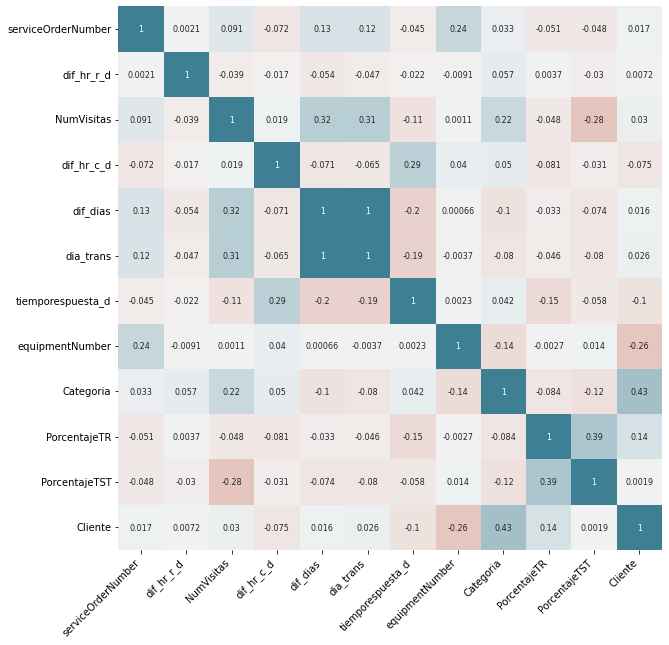

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix_Y,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

### Analisis de Significancia Por Region

In [70]:
import pingouin as pg

In [71]:
display(pg.corr(Procesos_resueltos_22_N['Categoria'], Procesos_resueltos_22_N['Cliente'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_N['dif_hr_c_d'], Procesos_resueltos_22_N['tiemporespuesta_d'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_N['PorcentajeTST'], Procesos_resueltos_22_N['NumVisitas'], method='pearson'))

n         r         CI95%  p-val BF10  power
pearson  18631  0.501584  [0.49, 0.51]    0.0  inf    1.0

n         r         CI95%          p-val       BF10  power
pearson  18631  0.167608  [0.15, 0.18]  1.882415e-117  1.65e+113    1.0

n         r           CI95%  p-val BF10  power
pearson  18631 -0.454149  [-0.47, -0.44]    0.0  inf    1.0

In [72]:
display(pg.corr(Procesos_resueltos_22_NO['Categoria'], Procesos_resueltos_22_NO['Cliente'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_NO['dif_hr_c_d'], Procesos_resueltos_22_NO['tiemporespuesta_d'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_NO['PorcentajeTST'], Procesos_resueltos_22_NO['NumVisitas'], method='pearson'))

n         r         CI95%          p-val        BF10  power
pearson  1772  0.497544  [0.46, 0.53]  1.831391e-111  4.656e+107    1.0

n         r         CI95%         p-val       BF10  power
pearson  1772  0.446754  [0.41, 0.48]  1.145514e-87  8.813e+83    1.0

n         r           CI95%         p-val       BF10  power
pearson  1772 -0.285895  [-0.33, -0.24]  1.109625e-34  1.624e+31    1.0

In [73]:
display(pg.corr(Procesos_resueltos_22_NE['Categoria'], Procesos_resueltos_22_NE['Cliente'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_NE['dif_hr_c_d'], Procesos_resueltos_22_NE['tiemporespuesta_d'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_NE['PorcentajeTST'], Procesos_resueltos_22_NE['NumVisitas'], method='pearson'))

n         r         CI95%  p-val BF10  power
pearson  13164  0.505002  [0.49, 0.52]    0.0  inf    1.0

n         r         CI95%         p-val       BF10  power
pearson  13164  0.163741  [0.15, 0.18]  8.954441e-80  5.029e+75    1.0

n         r           CI95%  p-val BF10  power
pearson  13164 -0.394019  [-0.41, -0.38]    0.0  inf    1.0

In [74]:
display(pg.corr(Procesos_resueltos_22_CO['Categoria'], Procesos_resueltos_22_CO['Cliente'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_CO['dif_hr_c_d'], Procesos_resueltos_22_CO['tiemporespuesta_d'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_CO['PorcentajeTST'], Procesos_resueltos_22_CO['NumVisitas'], method='pearson'))

n         r         CI95%  p-val BF10  power
pearson  68607  0.154212  [0.15, 0.16]    0.0  inf    1.0

n         r         CI95%  p-val BF10  power
pearson  68607  0.317592  [0.31, 0.32]    0.0  inf    1.0

n         r           CI95%  p-val BF10  power
pearson  68607 -0.381699  [-0.39, -0.38]    0.0  inf    1.0

In [75]:
display(pg.corr(Procesos_resueltos_22_CE['Categoria'], Procesos_resueltos_22_CE['Cliente'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_CE['dif_hr_c_d'], Procesos_resueltos_22_CE['tiemporespuesta_d'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_CE['PorcentajeTST'], Procesos_resueltos_22_CE['NumVisitas'], method='pearson'))

n         r        CI95%  p-val BF10  power
pearson  25857  0.407216  [0.4, 0.42]    0.0  inf    1.0

n         r        CI95%          p-val       BF10  power
pearson  25857  0.183344  [0.17, 0.2]  2.892303e-194  7.04e+189    1.0

n         r           CI95%  p-val BF10  power
pearson  25857 -0.364359  [-0.37, -0.35]    0.0  inf    1.0

In [76]:
display(pg.corr(Procesos_resueltos_22_OR['Categoria'], Procesos_resueltos_22_OR['Cliente'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_OR['dif_hr_c_d'], Procesos_resueltos_22_OR['tiemporespuesta_d'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_OR['PorcentajeTST'], Procesos_resueltos_22_OR['NumVisitas'], method='pearson'))

n         r         CI95%          p-val        BF10  power
pearson  1953  0.592492  [0.56, 0.62]  1.984304e-185  2.827e+181    1.0

n         r        CI95%         p-val       BF10  power
pearson  1953  0.344206  [0.3, 0.38]  1.965692e-55  6.649e+51    1.0

n         r          CI95%         p-val       BF10  power
pearson  1953 -0.262125  [-0.3, -0.22]  4.763669e-32  3.794e+28    1.0

In [77]:
display(pg.corr(Procesos_resueltos_22_S['Categoria'], Procesos_resueltos_22_S['Cliente'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_S['dif_hr_c_d'], Procesos_resueltos_22_S['tiemporespuesta_d'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_S['PorcentajeTST'], Procesos_resueltos_22_S['NumVisitas'], method='pearson'))

n         r        CI95%         p-val       BF10  power
pearson  550  0.659749  [0.61, 0.7]  5.206660e-70  2.995e+66    1.0

n         r         CI95%         p-val       BF10  power
pearson  550  0.381046  [0.31, 0.45]  1.898063e-20  2.131e+17    1.0

n         r           CI95%         p-val       BF10  power
pearson  550 -0.412821  [-0.48, -0.34]  4.784076e-24  7.589e+20    1.0

In [78]:
display(pg.corr(Procesos_resueltos_22_Y['Categoria'], Procesos_resueltos_22_Y['Cliente'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_Y['dif_hr_c_d'], Procesos_resueltos_22_Y['tiemporespuesta_d'], method='pearson'))
display(pg.corr(Procesos_resueltos_22_Y['PorcentajeTST'], Procesos_resueltos_22_Y['NumVisitas'], method='pearson'))

n         r         CI95%         p-val      BF10  power
pearson  427  0.433588  [0.35, 0.51]  5.332193e-21  8.17e+17    1.0

n         r        CI95%         p-val       BF10     power
pearson  427  0.293704  [0.2, 0.38]  6.081154e-10  1.173e+07  0.999991

n         r           CI95%         p-val       BF10     power
pearson  427 -0.276125  [-0.36, -0.19]  6.540813e-09  1.169e+06  0.999949

## Random Forrest Aplicado a Cada Region

### Region Norte

In [80]:
X_N=Procesos_resueltos_22_N[['dif_hr_r_d', 'dif_hr_c_d']]  # Datos a probar
y_N=Procesos_resueltos_22_N['tiemporespuesta_d']  # Datos a estimar
lab_N = preprocessing.LabelEncoder()
y_transformed_N = lab_N.fit_transform(y_N)
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(X_N, y_transformed_N, test_size=0.75)
clf=RandomForestClassifier(n_estimators=200, max_depth=2, n_jobs=2, max_features=2)
clf.fit(X_train_N,y_train_N)
y_pred_N=clf.predict(X_test_N)
print("Accuracy:",metrics.accuracy_score(y_test_N, y_pred_N)*24)

Accuracy: 0.3606698153714041


Valor óptimo de n_estimators: 141


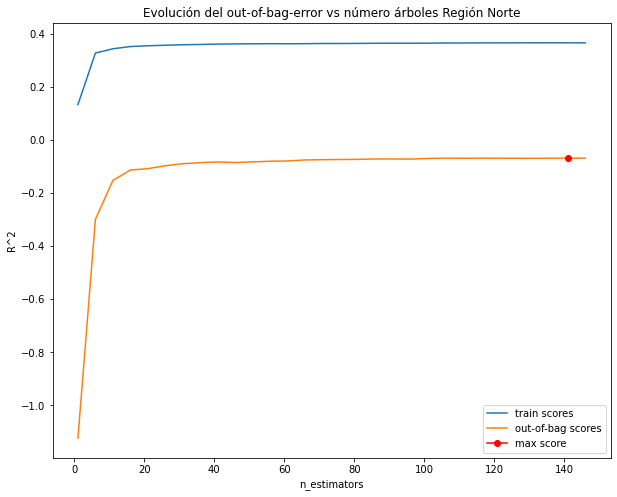

In [81]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train_N, y_train_N)
    train_scores.append(modelo.score(X_train_N, y_train_N))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles Región Norte")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

### Region Noroeste

In [95]:
X_NO=Procesos_resueltos_22_NO[['dif_hr_r_d', 'dif_hr_c_d']]  # Datos a probar
y_NO=Procesos_resueltos_22_NO['tiemporespuesta_d']  # Datos a estimar
lab_NO = preprocessing.LabelEncoder()
y_transformed_NO = lab_NO.fit_transform(y_NO)
X_train_NO, X_test_NO, y_train_NO, y_test_NO = train_test_split(X_NO, y_transformed_NO, test_size=0.75)
clf=RandomForestClassifier(n_estimators=200, max_depth=2, n_jobs=2, max_features=2)
clf.fit(X_train_NO,y_train_NO)
y_pred_NO=clf.predict(X_test_NO)
print("R^2:",metrics.mean_squared_error(y_test_NO, y_pred_NO))

R^2: 6806.92776523702


Valor óptimo de n_estimators: 136


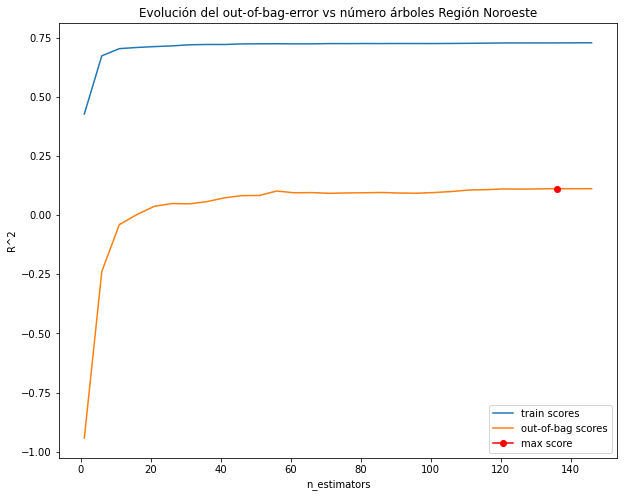

In [85]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train_NO, y_train_NO)
    train_scores.append(modelo.score(X_train_NO, y_train_NO))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles Región Noroeste")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

### Region Noreste

In [107]:
X_NE=Procesos_resueltos_22_NE[['dif_hr_r_d', 'dif_hr_c_d']]  # Datos a probar
y_NE=Procesos_resueltos_22_NE['tiemporespuesta_d']  # Datos a estimar
lab_NE = preprocessing.LabelEncoder()
y_transformed_NE = lab_NE.fit_transform(y_NE)
X_train_NE, X_test_NE, y_train_NE, y_test_NE = train_test_split(X_NE, y_transformed_NE, test_size=0.75)
clf=RandomForestClassifier(n_estimators=200, max_depth=2, n_jobs=2, max_features=2)
clf.fit(X_train_NE,y_train_NE)
y_pred_NE=clf.predict(X_test_NE)
print("R^2:",metrics.mean_squared_error(y_test_NE, y_pred_NE))

R^2: 3048.4761470677604


Valor óptimo de n_estimators: 146


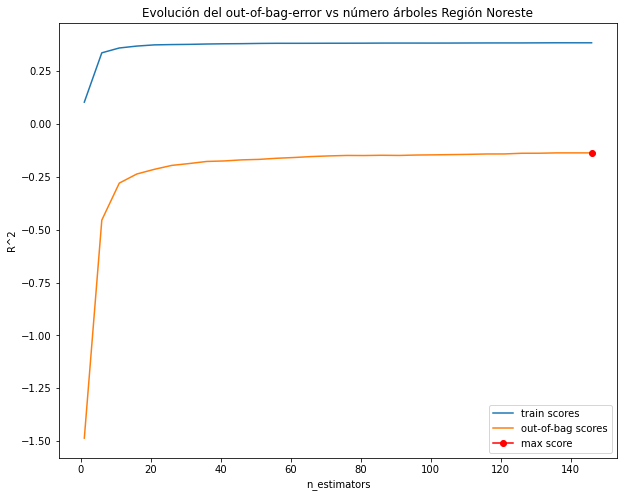

In [108]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train_NE, y_train_NE)
    train_scores.append(modelo.score(X_train_NE, y_train_NE))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles Región Noreste")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

### Region Centro Occidente

In [102]:
X_CO=Procesos_resueltos_22_CO[['dif_hr_r_d', 'dif_hr_c_d']]  # Datos a probar
y_CO=Procesos_resueltos_22_CO['tiemporespuesta_d']  # Datos a estimar
lab_CO = preprocessing.LabelEncoder()
y_transformed_CO = lab_CO.fit_transform(y_CO)
X_train_CO, X_test_CO, y_train_CO, y_test_CO = train_test_split(X_CO, y_transformed_CO, test_size=0.75)
clf=RandomForestClassifier(n_estimators=200, max_depth=2, n_jobs=2, max_features=2)
clf.fit(X_train_CO,y_train_CO)
y_pred_CO=clf.predict(X_test_CO)
print("Accuracy:",metrics.accuracy_score(y_test_CO, y_pred_CO)*24)

Accuracy: 0.43376865671641784


Valor óptimo de n_estimators: 121


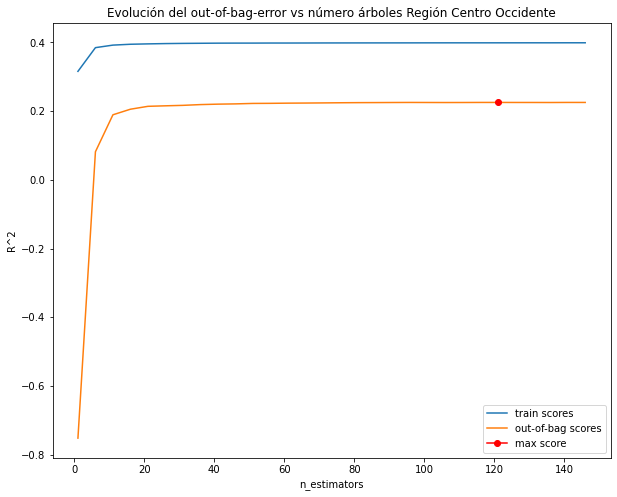

In [103]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train_CO, y_train_CO)
    train_scores.append(modelo.score(X_train_CO, y_train_CO))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles Región Centro Occidente")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

### Region Centro Este

In [109]:
X_CE=Procesos_resueltos_22_CE[['dif_hr_r_d', 'dif_hr_c_d']]  # Datos a probar
y_CE=Procesos_resueltos_22_CE['tiemporespuesta_d']  # Datos a estimar
lab_CE = preprocessing.LabelEncoder()
y_transformed_CE = lab_CE.fit_transform(y_CE)
X_train_CE, X_test_CE, y_train_CE, y_test_CE = train_test_split(X_CE, y_transformed_CE, test_size=0.75)
clf=RandomForestClassifier(n_estimators=200, max_depth=2, n_jobs=2, max_features=2)
clf.fit(X_train_CE,y_train_CE)
y_pred_CE=clf.predict(X_test_CE)
print("Accuracy:",metrics.accuracy_score(y_test_CE, y_pred_CE)*24)

Accuracy: 0.28463878719125457


Valor óptimo de n_estimators: 141


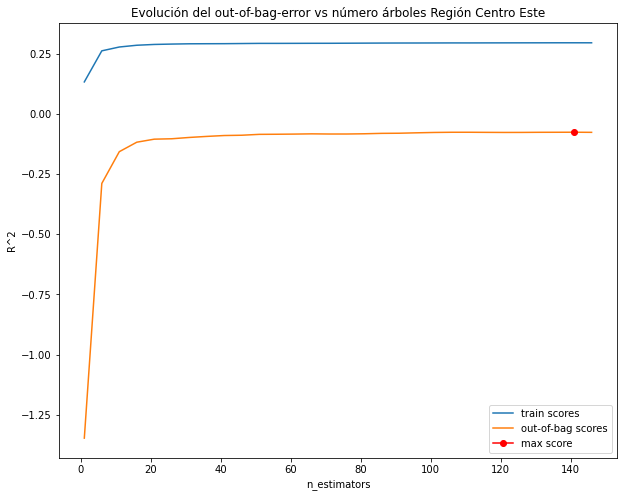

In [111]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train_CE, y_train_CE)
    train_scores.append(modelo.score(X_train_CE, y_train_CE))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles Región Centro Este")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

### Region Oriente

In [112]:
X_OR=Procesos_resueltos_22_OR[['dif_hr_r_d', 'dif_hr_c_d']]  # Datos a probar
y_OR=Procesos_resueltos_22_OR['tiemporespuesta_d']  # Datos a estimar
lab_OR = preprocessing.LabelEncoder()
y_transformed_OR = lab_OR.fit_transform(y_OR)
X_train_OR, X_test_OR, y_train_OR, y_test_OR = train_test_split(X_OR, y_transformed_OR, test_size=0.75)
clf=RandomForestClassifier(n_estimators=200, max_depth=2, n_jobs=2, max_features=2)
clf.fit(X_train_OR,y_train_OR)
y_pred_OR=clf.predict(X_test_OR)
print("Accuracy:",metrics.accuracy_score(y_test_OR, y_pred_OR)*24)

Accuracy: 0.31126279863481227


Valor óptimo de n_estimators: 106


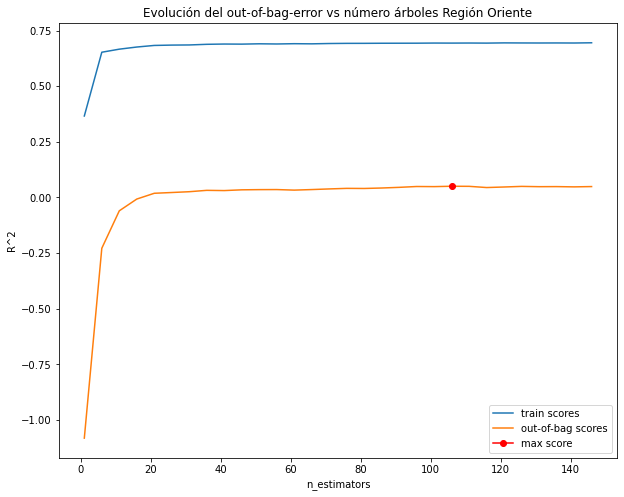

In [114]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train_OR, y_train_OR)
    train_scores.append(modelo.score(X_train_OR, y_train_OR))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles Región Oriente")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

### Region Sur

In [115]:
X_S=Procesos_resueltos_22_S[['dif_hr_r_d', 'dif_hr_c_d']]  # Datos a probar
y_S=Procesos_resueltos_22_S['tiemporespuesta_d']  # Datos a estimar
lab_S = preprocessing.LabelEncoder()
y_transformed_S = lab_S.fit_transform(y_S)
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_S, y_transformed_S, test_size=0.75)
clf=RandomForestClassifier(n_estimators=200, max_depth=2, n_jobs=2, max_features=2)
clf.fit(X_train_S,y_train_S)
y_pred_S=clf.predict(X_test_S)
print("Accuracy:",metrics.accuracy_score(y_test_S, y_pred_S)*24)

Accuracy: 0.29055690072639223


Valor óptimo de n_estimators: 61


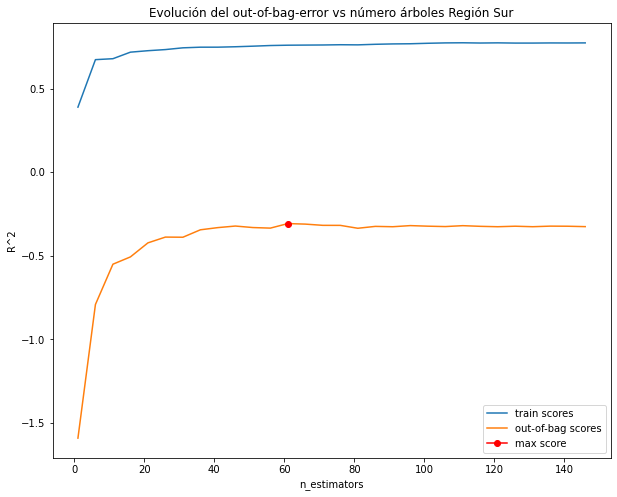

In [117]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train_S, y_train_S)
    train_scores.append(modelo.score(X_train_S, y_train_S))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles Región Sur")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

### Region Yucatán

In [118]:
X_Y=Procesos_resueltos_22_Y[['dif_hr_r_d', 'dif_hr_c_d']]  # Datos a probar
y_Y=Procesos_resueltos_22_Y['tiemporespuesta_d']  # Datos a estimar
lab_Y = preprocessing.LabelEncoder()
y_transformed_Y = lab_Y.fit_transform(y_Y)
X_train_Y, X_test_Y, y_train_Y, y_test_Y = train_test_split(X_Y, y_transformed_Y, test_size=0.75)
clf=RandomForestClassifier(n_estimators=200, max_depth=2, n_jobs=2, max_features=2)
clf.fit(X_train_Y,y_train_Y)
y_pred_Y=clf.predict(X_test_Y)
print("Accuracy:",metrics.accuracy_score(y_test_Y, y_pred_Y)*24)

Accuracy: 0.14953271028037382


Valor óptimo de n_estimators: 121


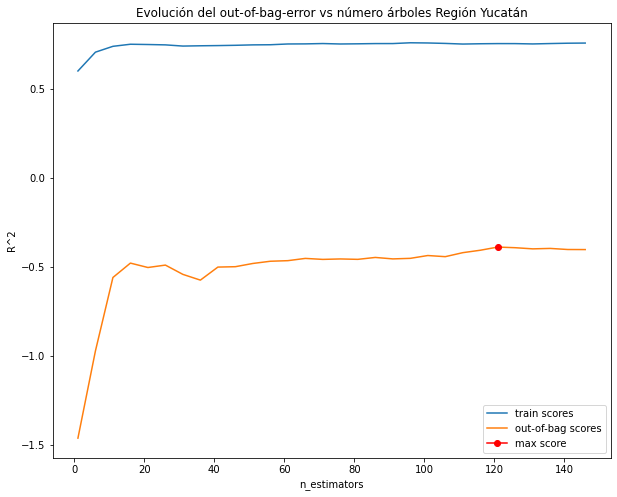

In [120]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train_Y, y_train_Y)
    train_scores.append(modelo.score(X_train_Y, y_train_Y))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles Región Yucatán")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")